# Flat Unrolled Cascade with Data Consistency (DC) - Train

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os
import glob
import sys
from scipy.io import loadmat
# Importing our model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import cs_models as fsnet
from  data_generator import DataGenerator
# Importing callbacks and data augmentation utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import  Adam

Using TensorFlow backend.


In [2]:
## PARAMETERS
H,W = 256,256 # Training image dimensions
channels = 2 # complex data 0-> real; 1-> imaginary
norm = np.sqrt(H*W)

# Train Set 
train_path = "/home/ubuntu/volume1/Raw_data/Kspace/Train/*.npy"
kspace_files_train = np.asarray(glob.glob(train_path))

# Validation set
val_path = "/home/ubuntu/volume1/Raw_data/Kspace/Val/*.npy"
kspace_files_val = np.asarray(glob.glob(val_path))

indexes = np.arange(kspace_files_train.size,dtype = int)
np.random.shuffle(indexes)
kspace_files_train = kspace_files_train[indexes]


print(kspace_files_train[-1])
print(len(kspace_files_train))

print(kspace_files_val[-1])
print(len(kspace_files_val))

/home/ubuntu/volume1/Raw_data/Kspace/Train/e14437s5_P49152.7.npy
25
/home/ubuntu/volume1/Raw_data/Kspace/Val/e14441s5_P76800.7.npy
10


In [3]:
offset = 5
# Get number of samples
ntrain = 0
for ii in range(len(kspace_files_train)):
    ntrain += (np.load(kspace_files_train[ii]).shape[0] - 2*offset)

# Load train data    
rec_train = np.zeros((ntrain,H,W,2))
aux_counter = 0
for ii in range(len(kspace_files_train)):
     aux_kspace = np.load(kspace_files_train[ii])/norm
     aux = int(aux_kspace.shape[0] - 2*offset)
     aux2 = np.fft.ifft2(aux_kspace[offset:-offset,:,:,0]+\
                         1j*aux_kspace[offset:-offset,:,:,1])
     rec_train[aux_counter:aux_counter+aux,:,:,0] = aux2.real
     rec_train[aux_counter:aux_counter+aux,:,:,1] = aux2.imag
     aux_counter+=aux

# Shuffle training    
indexes = np.arange(rec_train.shape[0],dtype = int)
np.random.shuffle(indexes)
rec_train = rec_train[indexes]
print("Number of training samples", rec_train.shape[0])

Number of training samples 4004


In [4]:
# Get number of samples
nval = 0
for ii in range(len(kspace_files_val)):
    nval += (np.load(kspace_files_val[ii]).shape[0] - 2*offset)

kspace_val = np.zeros((nval,H,W,2))
rec_val = np.zeros((nval,H,W,2))
aux_counter = 0
for ii in range(len(kspace_files_val)):
    aux_kspace = np.load(kspace_files_val[ii])/norm
    aux = int(aux_kspace.shape[0] - 2*offset)
    kspace_val[aux_counter:aux_counter+aux] = aux_kspace[offset:-offset]
    aux2 = np.fft.ifft2(aux_kspace[offset:-offset,:,:,0]+1j*aux_kspace[offset:-offset,:,:,1])
    rec_val[aux_counter:aux_counter+aux,:,:,0] = aux2.real
    rec_val[aux_counter:aux_counter+aux,:,:,1] = aux2.imag
    aux_counter+=aux

# Undersampling kspace
#rec_val = (rec_val-stats[0])/stats[1]
rec_val_abs = np.abs(rec_val[:,:,:,0]+1j*rec_val[:,:,:,1])[:,:,:,np.newaxis]

print("Number of samples", kspace_val.shape[0])

Number of samples 1600


In [5]:
epochs = 50
batch_size= 6

# Early stopping callback to shut down training after
#10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

In [6]:
def combine_generator(gen1,gen2,under_masks):
    while True:
        rec_real = gen1.next()
        rec_imag = gen2.next()
        kspace = np.fft.fft2(rec_real[:,:,:,0]+1j*rec_imag[:,:,:,0])
        kspace2 = np.zeros((kspace.shape[0],kspace.shape[1],kspace.shape[2],2))
        kspace2[:,:,:,0] = kspace.real
        kspace2[:,:,:,1] = kspace.imag
        indexes = np.random.choice(np.arange(under_masks.shape[0], dtype=int), rec_real.shape[0], replace=False)
        kspace2[under_masks[indexes]] = 0
        
        rec = np.abs(rec_real[:,:,:,0]+1j*rec_imag[:,:,:,0])[:,:,:,np.newaxis]
        rec_complex = np.zeros((rec.shape[0],rec.shape[1],rec.shape[2],2),dtype = np.float32)
        rec_complex[:,:,:,0] = rec_real[:,:,:,0]
        rec_complex[:,:,:,1] = rec_imag[:,:,:,0]
        
        yield([kspace2,under_masks[indexes].astype(np.float32)],[rec_complex,rec])

Undersampling: 0.8000030517578125
Mask type: bool


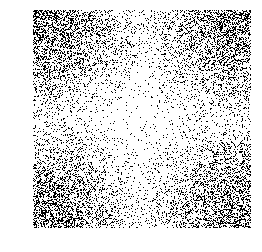

(6, 256, 256, 1)


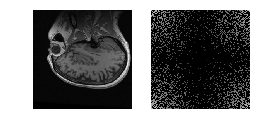

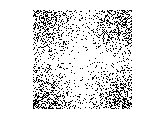

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 2)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 2)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 48) 912         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 48) 20784       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

Epoch 1/50
667/667 [==============================] - 112s 169ms/step - loss: 0.2056 - lambda_41_loss: 0.2289 - lambda_46_loss: 0.2056 - val_loss: 0.1446 - val_lambda_41_loss: 0.1609 - val_lambda_46_loss: 0.1446
Epoch 2/50
667/667 [==============================] - 106s 159ms/step - loss: 0.1402 - lambda_41_loss: 0.1642 - lambda_46_loss: 0.1402 - val_loss: 0.1124 - val_lambda_41_loss: 0.1404 - val_lambda_46_loss: 0.1124
Epoch 3/50
667/667 [==============================] - 106s 159ms/step - loss: 0.1125 - lambda_41_loss: 0.1296 - lambda_46_loss: 0.1125 - val_loss: 0.1044 - val_lambda_41_loss: 0.1250 - val_lambda_46_loss: 0.1044
Epoch 4/50
667/667 [==============================] - 106s 159ms/step - loss: 0.1018 - lambda_41_loss: 0.1169 - lambda_46_loss: 0.1018 - val_loss: 0.1032 - val_lambda_41_loss: 0.1155 - val_lambda_46_loss: 0.1032
Epoch 5/50
667/667 [==============================] - 106s 159ms/step - loss: 0.0972 - lambda_41_loss: 0.1100 - lambda_46_loss: 0.0972 - val_loss: 0.095

667/667 [==============================] - 106s 159ms/step - loss: 0.0691 - lambda_41_loss: 0.0768 - lambda_46_loss: 0.0691 - val_loss: 0.0773 - val_lambda_41_loss: 0.0847 - val_lambda_46_loss: 0.0773
Epoch 40/50
667/667 [==============================] - 106s 159ms/step - loss: 0.0700 - lambda_41_loss: 0.0777 - lambda_46_loss: 0.0700 - val_loss: 0.0791 - val_lambda_41_loss: 0.0881 - val_lambda_46_loss: 0.0791
Epoch 41/50
667/667 [==============================] - 106s 159ms/step - loss: 0.0691 - lambda_41_loss: 0.0769 - lambda_46_loss: 0.0691 - val_loss: 0.0831 - val_lambda_41_loss: 0.0928 - val_lambda_46_loss: 0.0831
Epoch 42/50
667/667 [==============================] - 106s 159ms/step - loss: 0.0694 - lambda_41_loss: 0.0772 - lambda_46_loss: 0.0694 - val_loss: 0.0794 - val_lambda_41_loss: 0.0883 - val_lambda_46_loss: 0.0794
Epoch 43/50
667/667 [==============================] - 106s 159ms/step - loss: 0.0678 - lambda_41_loss: 0.0750 - lambda_46_loss: 0.0678 - val_loss: 0.0893 - val

Epoch 1/50
667/667 [==============================] - 85s 127ms/step - loss: 0.2146 - lambda_81_loss: 0.2404 - lambda_86_loss: 0.2146 - val_loss: 0.1641 - val_lambda_81_loss: 0.1877 - val_lambda_86_loss: 0.1641
Epoch 2/50
667/667 [==============================] - 83s 124ms/step - loss: 0.1510 - lambda_81_loss: 0.1818 - lambda_86_loss: 0.1510 - val_loss: 0.1505 - val_lambda_81_loss: 0.1669 - val_lambda_86_loss: 0.1505
Epoch 3/50
667/667 [==============================] - 83s 124ms/step - loss: 0.1318 - lambda_81_loss: 0.1546 - lambda_86_loss: 0.1318 - val_loss: 0.1245 - val_lambda_81_loss: 0.1428 - val_lambda_86_loss: 0.1245
Epoch 4/50
667/667 [==============================] - 83s 124ms/step - loss: 0.1202 - lambda_81_loss: 0.1403 - lambda_86_loss: 0.1202 - val_loss: 0.1193 - val_lambda_81_loss: 0.1485 - val_lambda_86_loss: 0.1193
Epoch 5/50
667/667 [==============================] - 83s 124ms/step - loss: 0.1163 - lambda_81_loss: 0.1355 - lambda_86_loss: 0.1163 - val_loss: 0.1146 - v

Epoch 40/50
667/667 [==============================] - 83s 125ms/step - loss: 0.0871 - lambda_81_loss: 0.0999 - lambda_86_loss: 0.0871 - val_loss: 0.0937 - val_lambda_81_loss: 0.1092 - val_lambda_86_loss: 0.0937
Epoch 41/50
667/667 [==============================] - 83s 125ms/step - loss: 0.0859 - lambda_81_loss: 0.0991 - lambda_86_loss: 0.0859 - val_loss: 0.0997 - val_lambda_81_loss: 0.1190 - val_lambda_86_loss: 0.0997
Epoch 42/50
667/667 [==============================] - 83s 125ms/step - loss: 0.0870 - lambda_81_loss: 0.1002 - lambda_86_loss: 0.0870 - val_loss: 0.1048 - val_lambda_81_loss: 0.1220 - val_lambda_86_loss: 0.1048
Epoch 43/50
667/667 [==============================] - 83s 125ms/step - loss: 0.0868 - lambda_81_loss: 0.1000 - lambda_86_loss: 0.0868 - val_loss: 0.1075 - val_lambda_81_loss: 0.1222 - val_lambda_86_loss: 0.1075
Epoch 44/50
667/667 [==============================] - 83s 125ms/step - loss: 0.0866 - lambda_81_loss: 0.0997 - lambda_86_loss: 0.0866 - val_loss: 0.098

Epoch 13/50
667/667 [==============================] - 63s 94ms/step - loss: 0.2955 - lambda_91_loss: 0.3621 - lambda_96_loss: 0.2955 - val_loss: 0.2882 - val_lambda_91_loss: 0.3561 - val_lambda_96_loss: 0.2882
Epoch 14/50
667/667 [==============================] - 63s 95ms/step - loss: 0.2959 - lambda_91_loss: 0.3632 - lambda_96_loss: 0.2959 - val_loss: 0.2904 - val_lambda_91_loss: 0.3527 - val_lambda_96_loss: 0.2904
Epoch 15/50
667/667 [==============================] - 63s 94ms/step - loss: 0.2960 - lambda_91_loss: 0.3629 - lambda_96_loss: 0.2960 - val_loss: 0.2846 - val_lambda_91_loss: 0.3516 - val_lambda_96_loss: 0.2846
Epoch 16/50
667/667 [==============================] - 62s 93ms/step - loss: 0.2922 - lambda_91_loss: 0.3592 - lambda_96_loss: 0.2922 - val_loss: 0.2850 - val_lambda_91_loss: 0.3569 - val_lambda_96_loss: 0.2850
Epoch 17/50
667/667 [==============================] - 62s 93ms/step - loss: 0.2912 - lambda_91_loss: 0.3580 - lambda_96_loss: 0.2912 - val_loss: 0.2795 - v

Epoch 1/50
667/667 [==============================] - 64s 96ms/step - loss: 0.3131 - lambda_111_loss: 0.3399 - lambda_116_loss: 0.3131 - val_loss: 0.2833 - val_lambda_111_loss: 0.3176 - val_lambda_116_loss: 0.2833
Epoch 2/50
667/667 [==============================] - 62s 93ms/step - loss: 0.2743 - lambda_111_loss: 0.3015 - lambda_116_loss: 0.2743 - val_loss: 0.2647 - val_lambda_111_loss: 0.2904 - val_lambda_116_loss: 0.2647
Epoch 3/50
667/667 [==============================] - 62s 93ms/step - loss: 0.2628 - lambda_111_loss: 0.2894 - lambda_116_loss: 0.2628 - val_loss: 0.2667 - val_lambda_111_loss: 0.2967 - val_lambda_116_loss: 0.2667
Epoch 4/50
667/667 [==============================] - 63s 94ms/step - loss: 0.2580 - lambda_111_loss: 0.2847 - lambda_116_loss: 0.2580 - val_loss: 0.2487 - val_lambda_111_loss: 0.2768 - val_lambda_116_loss: 0.2487
Epoch 5/50
667/667 [==============================] - 61s 92ms/step - loss: 0.2544 - lambda_111_loss: 0.2812 - lambda_116_loss: 0.2544 - val_los

667/667 [==============================] - 61s 92ms/step - loss: 0.2283 - lambda_111_loss: 0.2557 - lambda_116_loss: 0.2283 - val_loss: 0.2425 - val_lambda_111_loss: 0.2657 - val_lambda_116_loss: 0.2425
Epoch 40/50
667/667 [==============================] - 61s 92ms/step - loss: 0.2267 - lambda_111_loss: 0.2538 - lambda_116_loss: 0.2267 - val_loss: 0.2306 - val_lambda_111_loss: 0.2590 - val_lambda_116_loss: 0.2306
Epoch 41/50
667/667 [==============================] - 61s 91ms/step - loss: 0.2256 - lambda_111_loss: 0.2530 - lambda_116_loss: 0.2256 - val_loss: 0.2372 - val_lambda_111_loss: 0.2640 - val_lambda_116_loss: 0.2372
Epoch 42/50
667/667 [==============================] - 62s 93ms/step - loss: 0.2262 - lambda_111_loss: 0.2538 - lambda_116_loss: 0.2262 - val_loss: 0.2385 - val_lambda_111_loss: 0.2650 - val_lambda_116_loss: 0.2385
Epoch 43/50
667/667 [==============================] - 62s 92ms/step - loss: 0.2253 - lambda_111_loss: 0.2526 - lambda_116_loss: 0.2253 - val_loss: 0.23

Epoch 2/50
667/667 [==============================] - 63s 95ms/step - loss: 0.3287 - lambda_121_loss: 0.3999 - lambda_126_loss: 0.3287 - val_loss: 0.3080 - val_lambda_121_loss: 0.3795 - val_lambda_126_loss: 0.3080
Epoch 3/50
667/667 [==============================] - 65s 97ms/step - loss: 0.3141 - lambda_121_loss: 0.3847 - lambda_126_loss: 0.3141 - val_loss: 0.3020 - val_lambda_121_loss: 0.3749 - val_lambda_126_loss: 0.3020
Epoch 4/50
667/667 [==============================] - 65s 98ms/step - loss: 0.3038 - lambda_121_loss: 0.3726 - lambda_126_loss: 0.3038 - val_loss: 0.3015 - val_lambda_121_loss: 0.3743 - val_lambda_126_loss: 0.3015
Epoch 5/50
667/667 [==============================] - 64s 96ms/step - loss: 0.2991 - lambda_121_loss: 0.3677 - lambda_126_loss: 0.2991 - val_loss: 0.2882 - val_lambda_121_loss: 0.3559 - val_lambda_126_loss: 0.2882
Epoch 6/50
667/667 [==============================] - 65s 97ms/step - loss: 0.2917 - lambda_121_loss: 0.3591 - lambda_126_loss: 0.2917 - val_los

667/667 [==============================] - 65s 97ms/step - loss: 0.2488 - lambda_121_loss: 0.3108 - lambda_126_loss: 0.2488 - val_loss: 0.2383 - val_lambda_121_loss: 0.3039 - val_lambda_126_loss: 0.2383
Epoch 41/50
667/667 [==============================] - 66s 99ms/step - loss: 0.2483 - lambda_121_loss: 0.3108 - lambda_126_loss: 0.2483 - val_loss: 0.2377 - val_lambda_121_loss: 0.3010 - val_lambda_126_loss: 0.2377
Epoch 42/50
667/667 [==============================] - 65s 97ms/step - loss: 0.2459 - lambda_121_loss: 0.3088 - lambda_126_loss: 0.2459 - val_loss: 0.2367 - val_lambda_121_loss: 0.2964 - val_lambda_126_loss: 0.2367
Epoch 43/50
667/667 [==============================] - 65s 97ms/step - loss: 0.2484 - lambda_121_loss: 0.3115 - lambda_126_loss: 0.2484 - val_loss: 0.2411 - val_lambda_121_loss: 0.3045 - val_lambda_126_loss: 0.2411
Epoch 44/50
667/667 [==============================] - 65s 98ms/step - loss: 0.2494 - lambda_121_loss: 0.3114 - lambda_126_loss: 0.2494 - val_loss: 0.23

Epoch 1/50
667/667 [==============================] - 68s 102ms/step - loss: 0.2436 - lambda_151_loss: 0.2761 - lambda_156_loss: 0.2436 - val_loss: 0.1940 - val_lambda_151_loss: 0.2135 - val_lambda_156_loss: 0.1940
Epoch 2/50
667/667 [==============================] - 65s 97ms/step - loss: 0.1841 - lambda_151_loss: 0.2143 - lambda_156_loss: 0.1841 - val_loss: 0.1930 - val_lambda_151_loss: 0.2371 - val_lambda_156_loss: 0.1930
Epoch 3/50
667/667 [==============================] - 65s 97ms/step - loss: 0.1715 - lambda_151_loss: 0.2015 - lambda_156_loss: 0.1715 - val_loss: 0.1639 - val_lambda_151_loss: 0.1927 - val_lambda_156_loss: 0.1639
Epoch 4/50
667/667 [==============================] - 65s 98ms/step - loss: 0.1609 - lambda_151_loss: 0.1909 - lambda_156_loss: 0.1609 - val_loss: 0.1515 - val_lambda_151_loss: 0.1794 - val_lambda_156_loss: 0.1515
Epoch 5/50
667/667 [==============================] - 65s 97ms/step - loss: 0.1559 - lambda_151_loss: 0.1850 - lambda_156_loss: 0.1559 - val_lo

667/667 [==============================] - 65s 97ms/step - loss: 0.1274 - lambda_151_loss: 0.1522 - lambda_156_loss: 0.1274 - val_loss: 0.1377 - val_lambda_151_loss: 0.1673 - val_lambda_156_loss: 0.1377
Epoch 40/50
667/667 [==============================] - 64s 96ms/step - loss: 0.1252 - lambda_151_loss: 0.1497 - lambda_156_loss: 0.1252 - val_loss: 0.1451 - val_lambda_151_loss: 0.1764 - val_lambda_156_loss: 0.1451
Epoch 41/50
667/667 [==============================] - 65s 97ms/step - loss: 0.1269 - lambda_151_loss: 0.1516 - lambda_156_loss: 0.1269 - val_loss: 0.1342 - val_lambda_151_loss: 0.1684 - val_lambda_156_loss: 0.1342
Epoch 42/50
667/667 [==============================] - 64s 96ms/step - loss: 0.1267 - lambda_151_loss: 0.1514 - lambda_156_loss: 0.1267 - val_loss: 0.1497 - val_lambda_151_loss: 0.1803 - val_lambda_156_loss: 0.1497
Epoch 43/50
667/667 [==============================] - 64s 96ms/step - loss: 0.1274 - lambda_151_loss: 0.1523 - lambda_156_loss: 0.1274 - val_loss: 0.16

Epoch 1/50
667/667 [==============================] - 67s 100ms/step - loss: 0.2626 - lambda_171_loss: 0.3063 - lambda_176_loss: 0.2626 - val_loss: 0.2192 - val_lambda_171_loss: 0.2621 - val_lambda_176_loss: 0.2192
Epoch 2/50
667/667 [==============================] - 64s 95ms/step - loss: 0.2105 - lambda_171_loss: 0.2532 - lambda_176_loss: 0.2105 - val_loss: 0.2018 - val_lambda_171_loss: 0.2388 - val_lambda_176_loss: 0.2018
Epoch 3/50
667/667 [==============================] - 63s 95ms/step - loss: 0.1971 - lambda_171_loss: 0.2387 - lambda_176_loss: 0.1971 - val_loss: 0.1926 - val_lambda_171_loss: 0.2341 - val_lambda_176_loss: 0.1926
Epoch 4/50
667/667 [==============================] - 64s 96ms/step - loss: 0.1905 - lambda_171_loss: 0.2319 - lambda_176_loss: 0.1905 - val_loss: 0.1886 - val_lambda_171_loss: 0.2285 - val_lambda_176_loss: 0.1886
Epoch 5/50
667/667 [==============================] - 64s 96ms/step - loss: 0.1854 - lambda_171_loss: 0.2264 - lambda_176_loss: 0.1854 - val_lo

667/667 [==============================] - 64s 96ms/step - loss: 0.1480 - lambda_171_loss: 0.1849 - lambda_176_loss: 0.1480 - val_loss: 0.1549 - val_lambda_171_loss: 0.1825 - val_lambda_176_loss: 0.1549
Epoch 40/50
667/667 [==============================] - 64s 96ms/step - loss: 0.1471 - lambda_171_loss: 0.1839 - lambda_176_loss: 0.1471 - val_loss: 0.1616 - val_lambda_171_loss: 0.1957 - val_lambda_176_loss: 0.1616
Epoch 41/50
667/667 [==============================] - 64s 96ms/step - loss: 0.1467 - lambda_171_loss: 0.1830 - lambda_176_loss: 0.1467 - val_loss: 0.1543 - val_lambda_171_loss: 0.1886 - val_lambda_176_loss: 0.1543
Epoch 42/50
667/667 [==============================] - 63s 94ms/step - loss: 0.1456 - lambda_171_loss: 0.1825 - lambda_176_loss: 0.1456 - val_loss: 0.1498 - val_lambda_171_loss: 0.1803 - val_lambda_176_loss: 0.1498
Epoch 43/50
667/667 [==============================] - 64s 96ms/step - loss: 0.1457 - lambda_171_loss: 0.1820 - lambda_176_loss: 0.1457 - val_loss: 0.15

Epoch 1/50
667/667 [==============================] - 67s 100ms/step - loss: 0.2691 - lambda_191_loss: 0.3010 - lambda_196_loss: 0.2691 - val_loss: 0.2452 - val_lambda_191_loss: 0.2862 - val_lambda_196_loss: 0.2452
Epoch 2/50
667/667 [==============================] - 64s 96ms/step - loss: 0.2151 - lambda_191_loss: 0.2486 - lambda_196_loss: 0.2151 - val_loss: 0.2024 - val_lambda_191_loss: 0.2337 - val_lambda_196_loss: 0.2024
Epoch 3/50
667/667 [==============================] - 64s 96ms/step - loss: 0.1951 - lambda_191_loss: 0.2290 - lambda_196_loss: 0.1951 - val_loss: 0.1904 - val_lambda_191_loss: 0.2201 - val_lambda_196_loss: 0.1904
Epoch 4/50
667/667 [==============================] - 64s 96ms/step - loss: 0.1841 - lambda_191_loss: 0.2180 - lambda_196_loss: 0.1841 - val_loss: 0.1726 - val_lambda_191_loss: 0.2063 - val_lambda_196_loss: 0.1726
Epoch 5/50
667/667 [==============================] - 64s 96ms/step - loss: 0.1794 - lambda_191_loss: 0.2134 - lambda_196_loss: 0.1794 - val_lo

667/667 [==============================] - 64s 96ms/step - loss: 0.1428 - lambda_191_loss: 0.1699 - lambda_196_loss: 0.1428 - val_loss: 0.1392 - val_lambda_191_loss: 0.1690 - val_lambda_196_loss: 0.1392
Epoch 40/50
667/667 [==============================] - 63s 95ms/step - loss: 0.1427 - lambda_191_loss: 0.1691 - lambda_196_loss: 0.1427 - val_loss: 0.1433 - val_lambda_191_loss: 0.1682 - val_lambda_196_loss: 0.1433
Epoch 41/50
667/667 [==============================] - 64s 96ms/step - loss: 0.1435 - lambda_191_loss: 0.1706 - lambda_196_loss: 0.1435 - val_loss: 0.1407 - val_lambda_191_loss: 0.1714 - val_lambda_196_loss: 0.1407
Epoch 42/50
667/667 [==============================] - 64s 95ms/step - loss: 0.1429 - lambda_191_loss: 0.1697 - lambda_196_loss: 0.1429 - val_loss: 0.1392 - val_lambda_191_loss: 0.1705 - val_lambda_196_loss: 0.1392
Epoch 43/50
667/667 [==============================] - 64s 96ms/step - loss: 0.1421 - lambda_191_loss: 0.1692 - lambda_196_loss: 0.1421 - val_loss: 0.14

Epoch 1/50
667/667 [==============================] - 83s 125ms/step - loss: 0.3793 - lambda_201_loss: 0.4510 - lambda_206_loss: 0.3793 - val_loss: 0.3317 - val_lambda_201_loss: 0.4046 - val_lambda_206_loss: 0.3317
Epoch 2/50
667/667 [==============================] - 80s 120ms/step - loss: 0.3242 - lambda_201_loss: 0.3946 - lambda_206_loss: 0.3242 - val_loss: 0.3027 - val_lambda_201_loss: 0.3677 - val_lambda_206_loss: 0.3027
Epoch 3/50
667/667 [==============================] - 80s 120ms/step - loss: 0.3077 - lambda_201_loss: 0.3762 - lambda_206_loss: 0.3077 - val_loss: 0.2994 - val_lambda_201_loss: 0.3712 - val_lambda_206_loss: 0.2994
Epoch 4/50
667/667 [==============================] - 80s 120ms/step - loss: 0.2943 - lambda_201_loss: 0.3615 - lambda_206_loss: 0.2943 - val_loss: 0.2816 - val_lambda_201_loss: 0.3537 - val_lambda_206_loss: 0.2816
Epoch 5/50
667/667 [==============================] - 80s 120ms/step - loss: 0.2882 - lambda_201_loss: 0.3544 - lambda_206_loss: 0.2882 - va

Epoch 39/50
667/667 [==============================] - 80s 120ms/step - loss: 0.2389 - lambda_201_loss: 0.2997 - lambda_206_loss: 0.2389 - val_loss: 0.2290 - val_lambda_201_loss: 0.2889 - val_lambda_206_loss: 0.2290
Epoch 40/50
667/667 [==============================] - 80s 120ms/step - loss: 0.2407 - lambda_201_loss: 0.3015 - lambda_206_loss: 0.2407 - val_loss: 0.2294 - val_lambda_201_loss: 0.2868 - val_lambda_206_loss: 0.2294
Epoch 41/50
667/667 [==============================] - 80s 120ms/step - loss: 0.2389 - lambda_201_loss: 0.3005 - lambda_206_loss: 0.2389 - val_loss: 0.2325 - val_lambda_201_loss: 0.2964 - val_lambda_206_loss: 0.2325
Epoch 42/50
667/667 [==============================] - 80s 120ms/step - loss: 0.2402 - lambda_201_loss: 0.3009 - lambda_206_loss: 0.2402 - val_loss: 0.2295 - val_lambda_201_loss: 0.2931 - val_lambda_206_loss: 0.2295
Epoch 43/50
667/667 [==============================] - 80s 120ms/step - loss: 0.2392 - lambda_201_loss: 0.2996 - lambda_206_loss: 0.2392

Epoch 1/50
667/667 [==============================] - 85s 128ms/step - loss: 0.2157 - lambda_231_loss: 0.2454 - lambda_236_loss: 0.2157 - val_loss: 0.1597 - val_lambda_231_loss: 0.1934 - val_lambda_236_loss: 0.1597
Epoch 2/50
667/667 [==============================] - 81s 122ms/step - loss: 0.1543 - lambda_231_loss: 0.1822 - lambda_236_loss: 0.1543 - val_loss: 0.1425 - val_lambda_231_loss: 0.1719 - val_lambda_236_loss: 0.1425
Epoch 3/50
667/667 [==============================] - 81s 122ms/step - loss: 0.1403 - lambda_231_loss: 0.1651 - lambda_236_loss: 0.1403 - val_loss: 0.1296 - val_lambda_231_loss: 0.1624 - val_lambda_236_loss: 0.1296
Epoch 4/50
667/667 [==============================] - 82s 122ms/step - loss: 0.1311 - lambda_231_loss: 0.1559 - lambda_236_loss: 0.1311 - val_loss: 0.1293 - val_lambda_231_loss: 0.1572 - val_lambda_236_loss: 0.1293
Epoch 5/50
667/667 [==============================] - 82s 122ms/step - loss: 0.1283 - lambda_231_loss: 0.1529 - lambda_236_loss: 0.1283 - va

Epoch 39/50
667/667 [==============================] - 82s 122ms/step - loss: 0.0942 - lambda_231_loss: 0.1084 - lambda_236_loss: 0.0942 - val_loss: 0.1074 - val_lambda_231_loss: 0.1277 - val_lambda_236_loss: 0.1074
Epoch 40/50
667/667 [==============================] - 82s 122ms/step - loss: 0.0948 - lambda_231_loss: 0.1095 - lambda_236_loss: 0.0948 - val_loss: 0.0969 - val_lambda_231_loss: 0.1095 - val_lambda_236_loss: 0.0969
Epoch 41/50
667/667 [==============================] - 82s 122ms/step - loss: 0.0949 - lambda_231_loss: 0.1091 - lambda_236_loss: 0.0949 - val_loss: 0.0977 - val_lambda_231_loss: 0.1110 - val_lambda_236_loss: 0.0977
Epoch 42/50
667/667 [==============================] - 82s 122ms/step - loss: 0.0944 - lambda_231_loss: 0.1088 - lambda_236_loss: 0.0944 - val_loss: 0.1014 - val_lambda_231_loss: 0.1202 - val_lambda_236_loss: 0.1014
Epoch 43/50
667/667 [==============================] - 82s 122ms/step - loss: 0.0933 - lambda_231_loss: 0.1073 - lambda_236_loss: 0.0933

Epoch 1/50
667/667 [==============================] - 85s 127ms/step - loss: 0.2567 - lambda_251_loss: 0.2948 - lambda_256_loss: 0.2567 - val_loss: 0.2260 - val_lambda_251_loss: 0.2553 - val_lambda_256_loss: 0.2260
Epoch 2/50
667/667 [==============================] - 81s 121ms/step - loss: 0.1992 - lambda_251_loss: 0.2374 - lambda_256_loss: 0.1992 - val_loss: 0.1812 - val_lambda_251_loss: 0.2214 - val_lambda_256_loss: 0.1812
Epoch 3/50
667/667 [==============================] - 81s 121ms/step - loss: 0.1817 - lambda_251_loss: 0.2186 - lambda_256_loss: 0.1817 - val_loss: 0.1684 - val_lambda_251_loss: 0.2110 - val_lambda_256_loss: 0.1684
Epoch 4/50
667/667 [==============================] - 81s 121ms/step - loss: 0.1716 - lambda_251_loss: 0.2074 - lambda_256_loss: 0.1716 - val_loss: 0.1681 - val_lambda_251_loss: 0.1972 - val_lambda_256_loss: 0.1681
Epoch 5/50
667/667 [==============================] - 81s 121ms/step - loss: 0.1644 - lambda_251_loss: 0.1994 - lambda_256_loss: 0.1644 - va

Epoch 39/50
667/667 [==============================] - 81s 121ms/step - loss: 0.1262 - lambda_251_loss: 0.1537 - lambda_256_loss: 0.1262 - val_loss: 0.1273 - val_lambda_251_loss: 0.1548 - val_lambda_256_loss: 0.1273
Epoch 40/50
667/667 [==============================] - 81s 121ms/step - loss: 0.1281 - lambda_251_loss: 0.1562 - lambda_256_loss: 0.1281 - val_loss: 0.1285 - val_lambda_251_loss: 0.1532 - val_lambda_256_loss: 0.1285
Epoch 41/50
667/667 [==============================] - 81s 121ms/step - loss: 0.1254 - lambda_251_loss: 0.1524 - lambda_256_loss: 0.1254 - val_loss: 0.1350 - val_lambda_251_loss: 0.1580 - val_lambda_256_loss: 0.1350
Epoch 42/50
667/667 [==============================] - 81s 121ms/step - loss: 0.1260 - lambda_251_loss: 0.1537 - lambda_256_loss: 0.1260 - val_loss: 0.1359 - val_lambda_251_loss: 0.1598 - val_lambda_256_loss: 0.1359
Epoch 43/50
667/667 [==============================] - 81s 121ms/step - loss: 0.1264 - lambda_251_loss: 0.1539 - lambda_256_loss: 0.1264

Epoch 1/50
667/667 [==============================] - 85s 128ms/step - loss: 0.2605 - lambda_271_loss: 0.2942 - lambda_276_loss: 0.2605 - val_loss: 0.1991 - val_lambda_271_loss: 0.2305 - val_lambda_276_loss: 0.1991
Epoch 2/50
667/667 [==============================] - 81s 121ms/step - loss: 0.2010 - lambda_271_loss: 0.2324 - lambda_276_loss: 0.2010 - val_loss: 0.1856 - val_lambda_271_loss: 0.2248 - val_lambda_276_loss: 0.1856
Epoch 3/50
667/667 [==============================] - 81s 122ms/step - loss: 0.1857 - lambda_271_loss: 0.2167 - lambda_276_loss: 0.1857 - val_loss: 0.1820 - val_lambda_271_loss: 0.2100 - val_lambda_276_loss: 0.1820
Epoch 4/50
667/667 [==============================] - 81s 122ms/step - loss: 0.1768 - lambda_271_loss: 0.2071 - lambda_276_loss: 0.1768 - val_loss: 0.1701 - val_lambda_271_loss: 0.2065 - val_lambda_276_loss: 0.1701
Epoch 5/50
667/667 [==============================] - 81s 121ms/step - loss: 0.1717 - lambda_271_loss: 0.2016 - lambda_276_loss: 0.1717 - va

Epoch 39/50
667/667 [==============================] - 81s 122ms/step - loss: 0.1330 - lambda_271_loss: 0.1564 - lambda_276_loss: 0.1330 - val_loss: 0.1324 - val_lambda_271_loss: 0.1584 - val_lambda_276_loss: 0.1324
Epoch 40/50
667/667 [==============================] - 81s 122ms/step - loss: 0.1345 - lambda_271_loss: 0.1578 - lambda_276_loss: 0.1345 - val_loss: 0.1320 - val_lambda_271_loss: 0.1563 - val_lambda_276_loss: 0.1320
Epoch 41/50
667/667 [==============================] - 81s 122ms/step - loss: 0.1336 - lambda_271_loss: 0.1566 - lambda_276_loss: 0.1336 - val_loss: 0.1314 - val_lambda_271_loss: 0.1615 - val_lambda_276_loss: 0.1314
Epoch 42/50
667/667 [==============================] - 81s 122ms/step - loss: 0.1336 - lambda_271_loss: 0.1575 - lambda_276_loss: 0.1336 - val_loss: 0.1521 - val_lambda_271_loss: 0.1845 - val_lambda_276_loss: 0.1521
Epoch 43/50
667/667 [==============================] - 81s 122ms/step - loss: 0.1333 - lambda_271_loss: 0.1569 - lambda_276_loss: 0.1333

Epoch 1/50
667/667 [==============================] - 86s 129ms/step - loss: 0.2210 - lambda_301_loss: 0.2616 - lambda_306_loss: 0.2210 - val_loss: 0.1806 - val_lambda_301_loss: 0.2126 - val_lambda_306_loss: 0.1806
Epoch 2/50
667/667 [==============================] - 81s 122ms/step - loss: 0.1689 - lambda_301_loss: 0.2028 - lambda_306_loss: 0.1689 - val_loss: 0.1639 - val_lambda_301_loss: 0.2029 - val_lambda_306_loss: 0.1639
Epoch 3/50
667/667 [==============================] - 82s 122ms/step - loss: 0.1548 - lambda_301_loss: 0.1861 - lambda_306_loss: 0.1548 - val_loss: 0.1518 - val_lambda_301_loss: 0.1789 - val_lambda_306_loss: 0.1518
Epoch 4/50
667/667 [==============================] - 82s 123ms/step - loss: 0.1455 - lambda_301_loss: 0.1735 - lambda_306_loss: 0.1455 - val_loss: 0.1476 - val_lambda_301_loss: 0.1725 - val_lambda_306_loss: 0.1476
Epoch 5/50
667/667 [==============================] - 82s 122ms/step - loss: 0.1429 - lambda_301_loss: 0.1722 - lambda_306_loss: 0.1429 - va

Epoch 39/50
667/667 [==============================] - 82s 123ms/step - loss: 0.1110 - lambda_301_loss: 0.1368 - lambda_306_loss: 0.1110 - val_loss: 0.1182 - val_lambda_301_loss: 0.1454 - val_lambda_306_loss: 0.1182
Epoch 40/50
667/667 [==============================] - 82s 122ms/step - loss: 0.1102 - lambda_301_loss: 0.1362 - lambda_306_loss: 0.1102 - val_loss: 0.1271 - val_lambda_301_loss: 0.1533 - val_lambda_306_loss: 0.1271
Epoch 41/50
667/667 [==============================] - 82s 122ms/step - loss: 0.1180 - lambda_301_loss: 0.1462 - lambda_306_loss: 0.1180 - val_loss: 0.1238 - val_lambda_301_loss: 0.1542 - val_lambda_306_loss: 0.1238
Epoch 42/50
667/667 [==============================] - 82s 122ms/step - loss: 0.1104 - lambda_301_loss: 0.1363 - lambda_306_loss: 0.1104 - val_loss: 0.1223 - val_lambda_301_loss: 0.1481 - val_lambda_306_loss: 0.1223
Epoch 43/50
667/667 [==============================] - 82s 122ms/step - loss: 0.1099 - lambda_301_loss: 0.1357 - lambda_306_loss: 0.1099

Epoch 1/50
667/667 [==============================] - 86s 130ms/step - loss: 0.2057 - lambda_331_loss: 0.2333 - lambda_336_loss: 0.2057 - val_loss: 0.1475 - val_lambda_331_loss: 0.1721 - val_lambda_336_loss: 0.1475
Epoch 2/50
667/667 [==============================] - 82s 123ms/step - loss: 0.1442 - lambda_331_loss: 0.1667 - lambda_336_loss: 0.1442 - val_loss: 0.1440 - val_lambda_331_loss: 0.1718 - val_lambda_336_loss: 0.1440
Epoch 3/50
667/667 [==============================] - 82s 123ms/step - loss: 0.1330 - lambda_331_loss: 0.1542 - lambda_336_loss: 0.1330 - val_loss: 0.1279 - val_lambda_331_loss: 0.1533 - val_lambda_336_loss: 0.1279
Epoch 4/50
667/667 [==============================] - 82s 123ms/step - loss: 0.1274 - lambda_331_loss: 0.1479 - lambda_336_loss: 0.1274 - val_loss: 0.1247 - val_lambda_331_loss: 0.1477 - val_lambda_336_loss: 0.1247
Epoch 5/50
667/667 [==============================] - 82s 123ms/step - loss: 0.1228 - lambda_331_loss: 0.1424 - lambda_336_loss: 0.1228 - va

Epoch 39/50
667/667 [==============================] - 82s 123ms/step - loss: 0.0945 - lambda_331_loss: 0.1087 - lambda_336_loss: 0.0945 - val_loss: 0.1060 - val_lambda_331_loss: 0.1269 - val_lambda_336_loss: 0.1060
Epoch 40/50
667/667 [==============================] - 82s 123ms/step - loss: 0.0947 - lambda_331_loss: 0.1089 - lambda_336_loss: 0.0947 - val_loss: 0.1044 - val_lambda_331_loss: 0.1223 - val_lambda_336_loss: 0.1044
Epoch 41/50
667/667 [==============================] - 82s 123ms/step - loss: 0.0940 - lambda_331_loss: 0.1080 - lambda_336_loss: 0.0940 - val_loss: 0.1053 - val_lambda_331_loss: 0.1246 - val_lambda_336_loss: 0.1053
Epoch 42/50
667/667 [==============================] - 82s 123ms/step - loss: 0.0943 - lambda_331_loss: 0.1083 - lambda_336_loss: 0.0943 - val_loss: 0.1079 - val_lambda_331_loss: 0.1268 - val_lambda_336_loss: 0.1079
Epoch 43/50
667/667 [==============================] - 82s 123ms/step - loss: 0.0938 - lambda_331_loss: 0.1078 - lambda_336_loss: 0.0938

Epoch 1/50
667/667 [==============================] - 87s 131ms/step - loss: 0.2200 - lambda_361_loss: 0.2600 - lambda_366_loss: 0.2200 - val_loss: 0.1688 - val_lambda_361_loss: 0.2042 - val_lambda_366_loss: 0.1688
Epoch 2/50
667/667 [==============================] - 82s 123ms/step - loss: 0.1664 - lambda_361_loss: 0.1994 - lambda_366_loss: 0.1664 - val_loss: 0.1566 - val_lambda_361_loss: 0.2019 - val_lambda_366_loss: 0.1566
Epoch 3/50
667/667 [==============================] - 82s 124ms/step - loss: 0.1535 - lambda_361_loss: 0.1845 - lambda_366_loss: 0.1535 - val_loss: 0.1461 - val_lambda_361_loss: 0.1796 - val_lambda_366_loss: 0.1461
Epoch 4/50
667/667 [==============================] - 82s 124ms/step - loss: 0.1452 - lambda_361_loss: 0.1736 - lambda_366_loss: 0.1452 - val_loss: 0.1412 - val_lambda_361_loss: 0.1793 - val_lambda_366_loss: 0.1412
Epoch 5/50
667/667 [==============================] - 82s 123ms/step - loss: 0.1405 - lambda_361_loss: 0.1692 - lambda_366_loss: 0.1405 - va

Epoch 39/50
667/667 [==============================] - 83s 124ms/step - loss: 0.1120 - lambda_361_loss: 0.1355 - lambda_366_loss: 0.1120 - val_loss: 0.1216 - val_lambda_361_loss: 0.1458 - val_lambda_366_loss: 0.1216
Epoch 40/50
667/667 [==============================] - 83s 124ms/step - loss: 0.1113 - lambda_361_loss: 0.1346 - lambda_366_loss: 0.1113 - val_loss: 0.1173 - val_lambda_361_loss: 0.1380 - val_lambda_366_loss: 0.1173
Epoch 41/50
667/667 [==============================] - 82s 123ms/step - loss: 0.1106 - lambda_361_loss: 0.1337 - lambda_366_loss: 0.1106 - val_loss: 0.1193 - val_lambda_361_loss: 0.1416 - val_lambda_366_loss: 0.1193
Epoch 42/50
667/667 [==============================] - 82s 123ms/step - loss: 0.1228 - lambda_361_loss: 0.1499 - lambda_366_loss: 0.1228 - val_loss: 0.1318 - val_lambda_361_loss: 0.1579 - val_lambda_366_loss: 0.1318
Epoch 43/50
667/667 [==============================] - 82s 123ms/step - loss: 0.1161 - lambda_361_loss: 0.1413 - lambda_366_loss: 0.1161

Epoch 1/50
667/667 [==============================] - 111s 166ms/step - loss: 0.1890 - lambda_401_loss: 0.2173 - lambda_406_loss: 0.1890 - val_loss: 0.1255 - val_lambda_401_loss: 0.1396 - val_lambda_406_loss: 0.1255
Epoch 2/50
667/667 [==============================] - 105s 158ms/step - loss: 0.1251 - lambda_401_loss: 0.1484 - lambda_406_loss: 0.1251 - val_loss: 0.1109 - val_lambda_401_loss: 0.1343 - val_lambda_406_loss: 0.1109
Epoch 3/50
667/667 [==============================] - 105s 158ms/step - loss: 0.1077 - lambda_401_loss: 0.1240 - lambda_406_loss: 0.1077 - val_loss: 0.1073 - val_lambda_401_loss: 0.1204 - val_lambda_406_loss: 0.1073
Epoch 4/50
667/667 [==============================] - 106s 158ms/step - loss: 0.1012 - lambda_401_loss: 0.1170 - lambda_406_loss: 0.1012 - val_loss: 0.1129 - val_lambda_401_loss: 0.1445 - val_lambda_406_loss: 0.1129
Epoch 5/50
667/667 [==============================] - 105s 158ms/step - loss: 0.0971 - lambda_401_loss: 0.1122 - lambda_406_loss: 0.0971

Epoch 39/50
667/667 [==============================] - 106s 159ms/step - loss: 0.0700 - lambda_401_loss: 0.0780 - lambda_406_loss: 0.0700 - val_loss: 0.0788 - val_lambda_401_loss: 0.0898 - val_lambda_406_loss: 0.0788
Epoch 40/50
667/667 [==============================] - 106s 158ms/step - loss: 0.0701 - lambda_401_loss: 0.0783 - lambda_406_loss: 0.0701 - val_loss: 0.0848 - val_lambda_401_loss: 0.0938 - val_lambda_406_loss: 0.0848
Epoch 41/50
667/667 [==============================] - 106s 158ms/step - loss: 0.0695 - lambda_401_loss: 0.0778 - lambda_406_loss: 0.0695 - val_loss: 0.0916 - val_lambda_401_loss: 0.1017 - val_lambda_406_loss: 0.0916
Epoch 42/50
667/667 [==============================] - 106s 158ms/step - loss: 0.0694 - lambda_401_loss: 0.0773 - lambda_406_loss: 0.0694 - val_loss: 0.0812 - val_lambda_401_loss: 0.0890 - val_lambda_406_loss: 0.0812
Epoch 43/50
667/667 [==============================] - 106s 158ms/step - loss: 0.0691 - lambda_401_loss: 0.0769 - lambda_406_loss: 0

Epoch 1/50
667/667 [==============================] - 110s 165ms/step - loss: 0.3776 - lambda_411_loss: 0.4484 - lambda_416_loss: 0.3776 - val_loss: 0.3248 - val_lambda_411_loss: 0.4006 - val_lambda_416_loss: 0.3248
Epoch 2/50
667/667 [==============================] - 104s 156ms/step - loss: 0.3142 - lambda_411_loss: 0.3832 - lambda_416_loss: 0.3142 - val_loss: 0.2858 - val_lambda_411_loss: 0.3591 - val_lambda_416_loss: 0.2858
Epoch 3/50
667/667 [==============================] - 104s 156ms/step - loss: 0.2985 - lambda_411_loss: 0.3653 - lambda_416_loss: 0.2985 - val_loss: 0.2905 - val_lambda_411_loss: 0.3599 - val_lambda_416_loss: 0.2905
Epoch 4/50
667/667 [==============================] - 104s 156ms/step - loss: 0.2881 - lambda_411_loss: 0.3537 - lambda_416_loss: 0.2881 - val_loss: 0.2786 - val_lambda_411_loss: 0.3511 - val_lambda_416_loss: 0.2786
Epoch 5/50
667/667 [==============================] - 104s 156ms/step - loss: 0.2796 - lambda_411_loss: 0.3443 - lambda_416_loss: 0.2796

Epoch 39/50
667/667 [==============================] - 104s 156ms/step - loss: 0.2308 - lambda_411_loss: 0.2898 - lambda_416_loss: 0.2308 - val_loss: 0.2191 - val_lambda_411_loss: 0.2784 - val_lambda_416_loss: 0.2191
Epoch 40/50
667/667 [==============================] - 104s 156ms/step - loss: 0.2313 - lambda_411_loss: 0.2902 - lambda_416_loss: 0.2313 - val_loss: 0.2216 - val_lambda_411_loss: 0.2792 - val_lambda_416_loss: 0.2216
Epoch 41/50
667/667 [==============================] - 104s 156ms/step - loss: 0.2310 - lambda_411_loss: 0.2897 - lambda_416_loss: 0.2310 - val_loss: 0.2280 - val_lambda_411_loss: 0.2803 - val_lambda_416_loss: 0.2280
Epoch 42/50
667/667 [==============================] - 104s 156ms/step - loss: 0.2291 - lambda_411_loss: 0.2883 - lambda_416_loss: 0.2291 - val_loss: 0.2219 - val_lambda_411_loss: 0.2815 - val_lambda_416_loss: 0.2219
Epoch 43/50
667/667 [==============================] - 104s 156ms/step - loss: 0.2292 - lambda_411_loss: 0.2879 - lambda_416_loss: 0

Epoch 1/50
667/667 [==============================] - 113s 169ms/step - loss: 0.1843 - lambda_451_loss: 0.2093 - lambda_456_loss: 0.1843 - val_loss: 0.1510 - val_lambda_451_loss: 0.1746 - val_lambda_456_loss: 0.1510
Epoch 2/50
667/667 [==============================] - 106s 158ms/step - loss: 0.1308 - lambda_451_loss: 0.1544 - lambda_456_loss: 0.1308 - val_loss: 0.1219 - val_lambda_451_loss: 0.1408 - val_lambda_456_loss: 0.1219
Epoch 3/50
667/667 [==============================] - 106s 159ms/step - loss: 0.1189 - lambda_451_loss: 0.1401 - lambda_456_loss: 0.1189 - val_loss: 0.1091 - val_lambda_451_loss: 0.1260 - val_lambda_456_loss: 0.1091
Epoch 4/50
667/667 [==============================] - 106s 159ms/step - loss: 0.1067 - lambda_451_loss: 0.1256 - lambda_456_loss: 0.1067 - val_loss: 0.1005 - val_lambda_451_loss: 0.1216 - val_lambda_456_loss: 0.1005
Epoch 5/50
667/667 [==============================] - 106s 160ms/step - loss: 0.1015 - lambda_451_loss: 0.1172 - lambda_456_loss: 0.1015

Epoch 39/50
667/667 [==============================] - 106s 159ms/step - loss: 0.0738 - lambda_451_loss: 0.0830 - lambda_456_loss: 0.0738 - val_loss: 0.0800 - val_lambda_451_loss: 0.0908 - val_lambda_456_loss: 0.0800
Epoch 40/50
667/667 [==============================] - 107s 160ms/step - loss: 0.0735 - lambda_451_loss: 0.0825 - lambda_456_loss: 0.0735 - val_loss: 0.0806 - val_lambda_451_loss: 0.0905 - val_lambda_456_loss: 0.0806
Epoch 41/50
667/667 [==============================] - 106s 160ms/step - loss: 0.0733 - lambda_451_loss: 0.0822 - lambda_456_loss: 0.0733 - val_loss: 0.0812 - val_lambda_451_loss: 0.0924 - val_lambda_456_loss: 0.0812
Epoch 42/50
667/667 [==============================] - 107s 160ms/step - loss: 0.0728 - lambda_451_loss: 0.0814 - lambda_456_loss: 0.0728 - val_loss: 0.0829 - val_lambda_451_loss: 0.0971 - val_lambda_456_loss: 0.0829
Epoch 43/50
667/667 [==============================] - 106s 160ms/step - loss: 0.0727 - lambda_451_loss: 0.0815 - lambda_456_loss: 0

Epoch 1/50
667/667 [==============================] - 113s 169ms/step - loss: 0.2146 - lambda_481_loss: 0.2442 - lambda_486_loss: 0.2146 - val_loss: 0.1537 - val_lambda_481_loss: 0.1862 - val_lambda_486_loss: 0.1537
Epoch 2/50
667/667 [==============================] - 105s 158ms/step - loss: 0.1549 - lambda_481_loss: 0.1818 - lambda_486_loss: 0.1549 - val_loss: 0.1399 - val_lambda_481_loss: 0.1649 - val_lambda_486_loss: 0.1399
Epoch 3/50
667/667 [==============================] - 106s 159ms/step - loss: 0.1386 - lambda_481_loss: 0.1623 - lambda_486_loss: 0.1386 - val_loss: 0.1330 - val_lambda_481_loss: 0.1558 - val_lambda_486_loss: 0.1330
Epoch 4/50
667/667 [==============================] - 106s 159ms/step - loss: 0.1312 - lambda_481_loss: 0.1542 - lambda_486_loss: 0.1312 - val_loss: 0.1310 - val_lambda_481_loss: 0.1533 - val_lambda_486_loss: 0.1310
Epoch 5/50
667/667 [==============================] - 106s 159ms/step - loss: 0.1280 - lambda_481_loss: 0.1518 - lambda_486_loss: 0.1280

Epoch 39/50
667/667 [==============================] - 106s 159ms/step - loss: 0.0921 - lambda_481_loss: 0.1049 - lambda_486_loss: 0.0921 - val_loss: 0.0945 - val_lambda_481_loss: 0.1087 - val_lambda_486_loss: 0.0945
Epoch 40/50
667/667 [==============================] - 106s 159ms/step - loss: 0.0920 - lambda_481_loss: 0.1054 - lambda_486_loss: 0.0920 - val_loss: 0.0958 - val_lambda_481_loss: 0.1090 - val_lambda_486_loss: 0.0958
Epoch 41/50
667/667 [==============================] - 106s 159ms/step - loss: 0.0911 - lambda_481_loss: 0.1035 - lambda_486_loss: 0.0911 - val_loss: 0.0931 - val_lambda_481_loss: 0.1051 - val_lambda_486_loss: 0.0931
Epoch 42/50
667/667 [==============================] - 106s 158ms/step - loss: 0.0909 - lambda_481_loss: 0.1036 - lambda_486_loss: 0.0909 - val_loss: 0.1014 - val_lambda_481_loss: 0.1248 - val_lambda_486_loss: 0.1014
Epoch 43/50
667/667 [==============================] - 106s 158ms/step - loss: 0.0909 - lambda_481_loss: 0.1041 - lambda_486_loss: 0

Epoch 1/50
667/667 [==============================] - 112s 168ms/step - loss: 0.2472 - lambda_501_loss: 0.2859 - lambda_506_loss: 0.2472 - val_loss: 0.2017 - val_lambda_501_loss: 0.2393 - val_lambda_506_loss: 0.2017
Epoch 2/50
667/667 [==============================] - 105s 157ms/step - loss: 0.1881 - lambda_501_loss: 0.2244 - lambda_506_loss: 0.1881 - val_loss: 0.1690 - val_lambda_501_loss: 0.2013 - val_lambda_506_loss: 0.1690
Epoch 3/50
667/667 [==============================] - 105s 158ms/step - loss: 0.1719 - lambda_501_loss: 0.2069 - lambda_506_loss: 0.1719 - val_loss: 0.1710 - val_lambda_501_loss: 0.2059 - val_lambda_506_loss: 0.1710
Epoch 4/50
667/667 [==============================] - 105s 158ms/step - loss: 0.1670 - lambda_501_loss: 0.2014 - lambda_506_loss: 0.1670 - val_loss: 0.1651 - val_lambda_501_loss: 0.1922 - val_lambda_506_loss: 0.1651
Epoch 5/50
667/667 [==============================] - 105s 158ms/step - loss: 0.1605 - lambda_501_loss: 0.1935 - lambda_506_loss: 0.1605

Epoch 39/50
667/667 [==============================] - 105s 158ms/step - loss: 0.1218 - lambda_501_loss: 0.1470 - lambda_506_loss: 0.1218 - val_loss: 0.1259 - val_lambda_501_loss: 0.1513 - val_lambda_506_loss: 0.1259
Epoch 40/50
667/667 [==============================] - 105s 157ms/step - loss: 0.1220 - lambda_501_loss: 0.1475 - lambda_506_loss: 0.1220 - val_loss: 0.1322 - val_lambda_501_loss: 0.1594 - val_lambda_506_loss: 0.1322
Epoch 41/50
667/667 [==============================] - 105s 158ms/step - loss: 0.1217 - lambda_501_loss: 0.1471 - lambda_506_loss: 0.1217 - val_loss: 0.1205 - val_lambda_501_loss: 0.1447 - val_lambda_506_loss: 0.1205
Epoch 42/50
667/667 [==============================] - 105s 158ms/step - loss: 0.1209 - lambda_501_loss: 0.1460 - lambda_506_loss: 0.1209 - val_loss: 0.1232 - val_lambda_501_loss: 0.1470 - val_lambda_506_loss: 0.1232
Epoch 43/50
667/667 [==============================] - 105s 158ms/step - loss: 0.1214 - lambda_501_loss: 0.1469 - lambda_506_loss: 0

Epoch 1/50
667/667 [==============================] - 113s 169ms/step - loss: 0.2612 - lambda_521_loss: 0.2955 - lambda_526_loss: 0.2612 - val_loss: 0.2011 - val_lambda_521_loss: 0.2276 - val_lambda_526_loss: 0.2011
Epoch 2/50
667/667 [==============================] - 105s 157ms/step - loss: 0.1989 - lambda_521_loss: 0.2311 - lambda_526_loss: 0.1989 - val_loss: 0.1793 - val_lambda_521_loss: 0.2042 - val_lambda_526_loss: 0.1793
Epoch 3/50
667/667 [==============================] - 105s 158ms/step - loss: 0.1824 - lambda_521_loss: 0.2155 - lambda_526_loss: 0.1824 - val_loss: 0.1696 - val_lambda_521_loss: 0.2055 - val_lambda_526_loss: 0.1696
Epoch 4/50
667/667 [==============================] - 105s 158ms/step - loss: 0.1742 - lambda_521_loss: 0.2059 - lambda_526_loss: 0.1742 - val_loss: 0.1808 - val_lambda_521_loss: 0.2330 - val_lambda_526_loss: 0.1808
Epoch 5/50
667/667 [==============================] - 105s 158ms/step - loss: 0.1691 - lambda_521_loss: 0.2008 - lambda_526_loss: 0.1691

Epoch 39/50
667/667 [==============================] - 106s 158ms/step - loss: 0.1321 - lambda_521_loss: 0.1556 - lambda_526_loss: 0.1321 - val_loss: 0.1304 - val_lambda_521_loss: 0.1533 - val_lambda_526_loss: 0.1304
Epoch 40/50
667/667 [==============================] - 106s 158ms/step - loss: 0.1319 - lambda_521_loss: 0.1561 - lambda_526_loss: 0.1319 - val_loss: 0.1315 - val_lambda_521_loss: 0.1580 - val_lambda_526_loss: 0.1315
Epoch 41/50
667/667 [==============================] - 106s 158ms/step - loss: 0.1301 - lambda_521_loss: 0.1531 - lambda_526_loss: 0.1301 - val_loss: 0.1335 - val_lambda_521_loss: 0.1639 - val_lambda_526_loss: 0.1335
Epoch 42/50
667/667 [==============================] - 105s 158ms/step - loss: 0.1309 - lambda_521_loss: 0.1542 - lambda_526_loss: 0.1309 - val_loss: 0.1309 - val_lambda_521_loss: 0.1540 - val_lambda_526_loss: 0.1309
Epoch 43/50
667/667 [==============================] - 105s 158ms/step - loss: 0.1297 - lambda_521_loss: 0.1528 - lambda_526_loss: 0

Epoch 1/50
667/667 [==============================] - 114s 171ms/step - loss: 0.2145 - lambda_551_loss: 0.2459 - lambda_556_loss: 0.2145 - val_loss: 0.1605 - val_lambda_551_loss: 0.1865 - val_lambda_556_loss: 0.1605
Epoch 2/50
667/667 [==============================] - 106s 159ms/step - loss: 0.1539 - lambda_551_loss: 0.1815 - lambda_556_loss: 0.1539 - val_loss: 0.1454 - val_lambda_551_loss: 0.1743 - val_lambda_556_loss: 0.1454
Epoch 3/50
667/667 [==============================] - 106s 159ms/step - loss: 0.1373 - lambda_551_loss: 0.1613 - lambda_556_loss: 0.1373 - val_loss: 0.1344 - val_lambda_551_loss: 0.1524 - val_lambda_556_loss: 0.1344
Epoch 4/50
667/667 [==============================] - 106s 160ms/step - loss: 0.1298 - lambda_551_loss: 0.1520 - lambda_556_loss: 0.1298 - val_loss: 0.1284 - val_lambda_551_loss: 0.1494 - val_lambda_556_loss: 0.1284
Epoch 5/50
667/667 [==============================] - 107s 160ms/step - loss: 0.1234 - lambda_551_loss: 0.1455 - lambda_556_loss: 0.1234

Epoch 39/50
667/667 [==============================] - 106s 159ms/step - loss: 0.0916 - lambda_551_loss: 0.1070 - lambda_556_loss: 0.0916 - val_loss: 0.0982 - val_lambda_551_loss: 0.1135 - val_lambda_556_loss: 0.0982
Epoch 40/50
667/667 [==============================] - 106s 159ms/step - loss: 0.0913 - lambda_551_loss: 0.1063 - lambda_556_loss: 0.0913 - val_loss: 0.1076 - val_lambda_551_loss: 0.1247 - val_lambda_556_loss: 0.1076
Epoch 41/50
667/667 [==============================] - 106s 160ms/step - loss: 0.0912 - lambda_551_loss: 0.1063 - lambda_556_loss: 0.0912 - val_loss: 0.0995 - val_lambda_551_loss: 0.1149 - val_lambda_556_loss: 0.0995
Epoch 42/50
667/667 [==============================] - 106s 159ms/step - loss: 0.0895 - lambda_551_loss: 0.1038 - lambda_556_loss: 0.0895 - val_loss: 0.1007 - val_lambda_551_loss: 0.1175 - val_lambda_556_loss: 0.1007
Epoch 43/50
667/667 [==============================] - 106s 159ms/step - loss: 0.0901 - lambda_551_loss: 0.1045 - lambda_556_loss: 0

Epoch 1/50
667/667 [==============================] - 115s 172ms/step - loss: 0.2029 - lambda_581_loss: 0.2297 - lambda_586_loss: 0.2029 - val_loss: 0.1616 - val_lambda_581_loss: 0.1856 - val_lambda_586_loss: 0.1616
Epoch 2/50
667/667 [==============================] - 106s 159ms/step - loss: 0.1468 - lambda_581_loss: 0.1702 - lambda_586_loss: 0.1468 - val_loss: 0.1332 - val_lambda_581_loss: 0.1547 - val_lambda_586_loss: 0.1332
Epoch 3/50
667/667 [==============================] - 106s 160ms/step - loss: 0.1346 - lambda_581_loss: 0.1554 - lambda_586_loss: 0.1346 - val_loss: 0.1248 - val_lambda_581_loss: 0.1440 - val_lambda_586_loss: 0.1248
Epoch 4/50
667/667 [==============================] - 107s 160ms/step - loss: 0.1265 - lambda_581_loss: 0.1460 - lambda_586_loss: 0.1265 - val_loss: 0.1266 - val_lambda_581_loss: 0.1463 - val_lambda_586_loss: 0.1266
Epoch 5/50
667/667 [==============================] - 107s 160ms/step - loss: 0.1228 - lambda_581_loss: 0.1427 - lambda_586_loss: 0.1228

Epoch 39/50
667/667 [==============================] - 106s 160ms/step - loss: 0.0913 - lambda_581_loss: 0.1065 - lambda_586_loss: 0.0913 - val_loss: 0.0992 - val_lambda_581_loss: 0.1155 - val_lambda_586_loss: 0.0992
Epoch 40/50
667/667 [==============================] - 107s 160ms/step - loss: 0.0905 - lambda_581_loss: 0.1054 - lambda_586_loss: 0.0905 - val_loss: 0.1001 - val_lambda_581_loss: 0.1134 - val_lambda_586_loss: 0.1001
Epoch 41/50
667/667 [==============================] - 107s 160ms/step - loss: 0.0904 - lambda_581_loss: 0.1052 - lambda_586_loss: 0.0904 - val_loss: 0.0955 - val_lambda_581_loss: 0.1124 - val_lambda_586_loss: 0.0955
Epoch 42/50
667/667 [==============================] - 106s 160ms/step - loss: 0.0903 - lambda_581_loss: 0.1053 - lambda_586_loss: 0.0903 - val_loss: 0.1021 - val_lambda_581_loss: 0.1205 - val_lambda_586_loss: 0.1021
Epoch 43/50
667/667 [==============================] - 107s 160ms/step - loss: 0.0899 - lambda_581_loss: 0.1048 - lambda_586_loss: 0

Epoch 1/50
667/667 [==============================] - 115s 172ms/step - loss: 0.2058 - lambda_611_loss: 0.2358 - lambda_616_loss: 0.2058 - val_loss: 0.1665 - val_lambda_611_loss: 0.2041 - val_lambda_616_loss: 0.1665
Epoch 2/50
667/667 [==============================] - 106s 159ms/step - loss: 0.1480 - lambda_611_loss: 0.1738 - lambda_616_loss: 0.1480 - val_loss: 0.1399 - val_lambda_611_loss: 0.1607 - val_lambda_616_loss: 0.1399
Epoch 3/50
667/667 [==============================] - 106s 159ms/step - loss: 0.1363 - lambda_611_loss: 0.1608 - lambda_616_loss: 0.1363 - val_loss: 0.1542 - val_lambda_611_loss: 0.2597 - val_lambda_616_loss: 0.1542
Epoch 4/50
667/667 [==============================] - 107s 160ms/step - loss: 0.1290 - lambda_611_loss: 0.1520 - lambda_616_loss: 0.1290 - val_loss: 0.1292 - val_lambda_611_loss: 0.1446 - val_lambda_616_loss: 0.1292
Epoch 5/50
667/667 [==============================] - 107s 160ms/step - loss: 0.1223 - lambda_611_loss: 0.1437 - lambda_616_loss: 0.1223

Epoch 39/50
667/667 [==============================] - 105s 158ms/step - loss: 0.0899 - lambda_611_loss: 0.1049 - lambda_616_loss: 0.0899 - val_loss: 0.0965 - val_lambda_611_loss: 0.1095 - val_lambda_616_loss: 0.0965
Epoch 40/50
667/667 [==============================] - 105s 157ms/step - loss: 0.0905 - lambda_611_loss: 0.1053 - lambda_616_loss: 0.0905 - val_loss: 0.0971 - val_lambda_611_loss: 0.1125 - val_lambda_616_loss: 0.0971
Epoch 41/50
667/667 [==============================] - 105s 157ms/step - loss: 0.0894 - lambda_611_loss: 0.1036 - lambda_616_loss: 0.0894 - val_loss: 0.0958 - val_lambda_611_loss: 0.1114 - val_lambda_616_loss: 0.0958
Epoch 42/50
667/667 [==============================] - 105s 158ms/step - loss: 0.0893 - lambda_611_loss: 0.1035 - lambda_616_loss: 0.0893 - val_loss: 0.1000 - val_lambda_611_loss: 0.1136 - val_lambda_616_loss: 0.1000
Epoch 43/50
667/667 [==============================] - 105s 157ms/step - loss: 0.0896 - lambda_611_loss: 0.1043 - lambda_616_loss: 0

Epoch 1/50
667/667 [==============================] - 113s 169ms/step - loss: 0.2482 - lambda_631_loss: 0.2931 - lambda_636_loss: 0.2482 - val_loss: 0.2048 - val_lambda_631_loss: 0.2552 - val_lambda_636_loss: 0.2048
Epoch 2/50
667/667 [==============================] - 105s 157ms/step - loss: 0.1999 - lambda_631_loss: 0.2419 - lambda_636_loss: 0.1999 - val_loss: 0.1831 - val_lambda_631_loss: 0.2232 - val_lambda_636_loss: 0.1831
Epoch 3/50
667/667 [==============================] - 105s 157ms/step - loss: 0.1889 - lambda_631_loss: 0.2293 - lambda_636_loss: 0.1889 - val_loss: 0.1802 - val_lambda_631_loss: 0.2173 - val_lambda_636_loss: 0.1802
Epoch 4/50
667/667 [==============================] - 105s 158ms/step - loss: 0.1805 - lambda_631_loss: 0.2204 - lambda_636_loss: 0.1805 - val_loss: 0.1738 - val_lambda_631_loss: 0.2128 - val_lambda_636_loss: 0.1738
Epoch 5/50
667/667 [==============================] - 105s 158ms/step - loss: 0.1745 - lambda_631_loss: 0.2142 - lambda_636_loss: 0.1745

Epoch 39/50
667/667 [==============================] - 105s 157ms/step - loss: 0.1353 - lambda_631_loss: 0.1691 - lambda_636_loss: 0.1353 - val_loss: 0.1445 - val_lambda_631_loss: 0.1777 - val_lambda_636_loss: 0.1445
Epoch 40/50
667/667 [==============================] - 105s 157ms/step - loss: 0.1360 - lambda_631_loss: 0.1697 - lambda_636_loss: 0.1360 - val_loss: 0.1506 - val_lambda_631_loss: 0.1796 - val_lambda_636_loss: 0.1506
Epoch 41/50
667/667 [==============================] - 105s 157ms/step - loss: 0.1357 - lambda_631_loss: 0.1691 - lambda_636_loss: 0.1357 - val_loss: 0.1511 - val_lambda_631_loss: 0.1820 - val_lambda_636_loss: 0.1511
Epoch 42/50
667/667 [==============================] - 105s 157ms/step - loss: 0.1344 - lambda_631_loss: 0.1676 - lambda_636_loss: 0.1344 - val_loss: 0.1388 - val_lambda_631_loss: 0.1698 - val_lambda_636_loss: 0.1388
Epoch 43/50
667/667 [==============================] - 105s 158ms/step - loss: 0.1347 - lambda_631_loss: 0.1679 - lambda_636_loss: 0

Epoch 1/50
667/667 [==============================] - 114s 171ms/step - loss: 0.2036 - lambda_661_loss: 0.2338 - lambda_666_loss: 0.2036 - val_loss: 0.1452 - val_lambda_661_loss: 0.1664 - val_lambda_666_loss: 0.1452
Epoch 2/50
667/667 [==============================] - 105s 158ms/step - loss: 0.1433 - lambda_661_loss: 0.1684 - lambda_666_loss: 0.1433 - val_loss: 0.1301 - val_lambda_661_loss: 0.1576 - val_lambda_666_loss: 0.1301
Epoch 3/50
667/667 [==============================] - 106s 158ms/step - loss: 0.1294 - lambda_661_loss: 0.1513 - lambda_666_loss: 0.1294 - val_loss: 0.1396 - val_lambda_661_loss: 0.1644 - val_lambda_666_loss: 0.1396
Epoch 4/50
667/667 [==============================] - 106s 158ms/step - loss: 0.1245 - lambda_661_loss: 0.1455 - lambda_666_loss: 0.1245 - val_loss: 0.1186 - val_lambda_661_loss: 0.1354 - val_lambda_666_loss: 0.1186
Epoch 5/50
667/667 [==============================] - 106s 158ms/step - loss: 0.1186 - lambda_661_loss: 0.1383 - lambda_666_loss: 0.1186

Epoch 39/50
667/667 [==============================] - 106s 158ms/step - loss: 0.0900 - lambda_661_loss: 0.1046 - lambda_666_loss: 0.0900 - val_loss: 0.1075 - val_lambda_661_loss: 0.1292 - val_lambda_666_loss: 0.1075
Epoch 40/50
667/667 [==============================] - 106s 158ms/step - loss: 0.0901 - lambda_661_loss: 0.1046 - lambda_666_loss: 0.0901 - val_loss: 0.1014 - val_lambda_661_loss: 0.1164 - val_lambda_666_loss: 0.1014
Epoch 41/50
667/667 [==============================] - 106s 158ms/step - loss: 0.0886 - lambda_661_loss: 0.1030 - lambda_666_loss: 0.0886 - val_loss: 0.0966 - val_lambda_661_loss: 0.1101 - val_lambda_666_loss: 0.0966
Epoch 42/50
667/667 [==============================] - 106s 158ms/step - loss: 0.0892 - lambda_661_loss: 0.1036 - lambda_666_loss: 0.0892 - val_loss: 0.1032 - val_lambda_661_loss: 0.1206 - val_lambda_666_loss: 0.1032
Epoch 43/50
667/667 [==============================] - 106s 158ms/step - loss: 0.0885 - lambda_661_loss: 0.1028 - lambda_666_loss: 0

Epoch 1/50
667/667 [==============================] - 115s 172ms/step - loss: 0.2034 - lambda_691_loss: 0.2313 - lambda_696_loss: 0.2034 - val_loss: 0.1491 - val_lambda_691_loss: 0.1724 - val_lambda_696_loss: 0.1491
Epoch 2/50
667/667 [==============================] - 105s 158ms/step - loss: 0.1436 - lambda_691_loss: 0.1664 - lambda_696_loss: 0.1436 - val_loss: 0.1294 - val_lambda_691_loss: 0.1544 - val_lambda_696_loss: 0.1294
Epoch 3/50
667/667 [==============================] - 106s 159ms/step - loss: 0.1321 - lambda_691_loss: 0.1539 - lambda_696_loss: 0.1321 - val_loss: 0.1317 - val_lambda_691_loss: 0.1556 - val_lambda_696_loss: 0.1317
Epoch 4/50
667/667 [==============================] - 106s 159ms/step - loss: 0.1238 - lambda_691_loss: 0.1440 - lambda_696_loss: 0.1238 - val_loss: 0.1310 - val_lambda_691_loss: 0.1502 - val_lambda_696_loss: 0.1310
Epoch 5/50
667/667 [==============================] - 106s 159ms/step - loss: 0.1207 - lambda_691_loss: 0.1404 - lambda_696_loss: 0.1207

Epoch 39/50
667/667 [==============================] - 106s 158ms/step - loss: 0.0919 - lambda_691_loss: 0.1055 - lambda_696_loss: 0.0919 - val_loss: 0.1039 - val_lambda_691_loss: 0.1207 - val_lambda_696_loss: 0.1039
Epoch 40/50
667/667 [==============================] - 106s 159ms/step - loss: 0.0918 - lambda_691_loss: 0.1054 - lambda_696_loss: 0.0918 - val_loss: 0.1024 - val_lambda_691_loss: 0.1226 - val_lambda_696_loss: 0.1024
Epoch 41/50
667/667 [==============================] - 106s 159ms/step - loss: 0.0915 - lambda_691_loss: 0.1050 - lambda_696_loss: 0.0915 - val_loss: 0.1015 - val_lambda_691_loss: 0.1189 - val_lambda_696_loss: 0.1015
Epoch 42/50
667/667 [==============================] - 106s 159ms/step - loss: 0.0913 - lambda_691_loss: 0.1047 - lambda_696_loss: 0.0913 - val_loss: 0.1156 - val_lambda_691_loss: 0.1326 - val_lambda_696_loss: 0.1156
Epoch 43/50
667/667 [==============================] - 106s 159ms/step - loss: 0.0909 - lambda_691_loss: 0.1041 - lambda_696_loss: 0

Epoch 1/50
667/667 [==============================] - 116s 174ms/step - loss: 0.2009 - lambda_731_loss: 0.2403 - lambda_736_loss: 0.2009 - val_loss: 0.1533 - val_lambda_731_loss: 0.1911 - val_lambda_736_loss: 0.1533
Epoch 2/50
667/667 [==============================] - 106s 159ms/step - loss: 0.1405 - lambda_731_loss: 0.1683 - lambda_736_loss: 0.1405 - val_loss: 0.1322 - val_lambda_731_loss: 0.1560 - val_lambda_736_loss: 0.1322
Epoch 3/50
667/667 [==============================] - 107s 160ms/step - loss: 0.1243 - lambda_731_loss: 0.1487 - lambda_736_loss: 0.1243 - val_loss: 0.1245 - val_lambda_731_loss: 0.1454 - val_lambda_736_loss: 0.1245
Epoch 4/50
667/667 [==============================] - 107s 161ms/step - loss: 0.1184 - lambda_731_loss: 0.1412 - lambda_736_loss: 0.1184 - val_loss: 0.1228 - val_lambda_731_loss: 0.1443 - val_lambda_736_loss: 0.1228
Epoch 5/50
667/667 [==============================] - 107s 161ms/step - loss: 0.1110 - lambda_731_loss: 0.1315 - lambda_736_loss: 0.1110

Epoch 39/50
667/667 [==============================] - 107s 161ms/step - loss: 0.0838 - lambda_731_loss: 0.0971 - lambda_736_loss: 0.0838 - val_loss: 0.0990 - val_lambda_731_loss: 0.1108 - val_lambda_736_loss: 0.0990
Epoch 40/50
667/667 [==============================] - 107s 161ms/step - loss: 0.0824 - lambda_731_loss: 0.0955 - lambda_736_loss: 0.0824 - val_loss: 0.0936 - val_lambda_731_loss: 0.1068 - val_lambda_736_loss: 0.0936
Epoch 41/50
667/667 [==============================] - 107s 161ms/step - loss: 0.0817 - lambda_731_loss: 0.0945 - lambda_736_loss: 0.0817 - val_loss: 0.0939 - val_lambda_731_loss: 0.1075 - val_lambda_736_loss: 0.0939
Epoch 42/50
667/667 [==============================] - 107s 161ms/step - loss: 0.0830 - lambda_731_loss: 0.0964 - lambda_736_loss: 0.0830 - val_loss: 0.0939 - val_lambda_731_loss: 0.1103 - val_lambda_736_loss: 0.0939
Epoch 43/50
667/667 [==============================] - 107s 160ms/step - loss: 0.0821 - lambda_731_loss: 0.0951 - lambda_736_loss: 0

Epoch 1/50
667/667 [==============================] - 116s 174ms/step - loss: 0.1867 - lambda_771_loss: 0.2111 - lambda_776_loss: 0.1867 - val_loss: 0.1348 - val_lambda_771_loss: 0.1533 - val_lambda_776_loss: 0.1348
Epoch 2/50
667/667 [==============================] - 106s 159ms/step - loss: 0.1330 - lambda_771_loss: 0.1564 - lambda_776_loss: 0.1330 - val_loss: 0.1341 - val_lambda_771_loss: 0.1619 - val_lambda_776_loss: 0.1341
Epoch 3/50
667/667 [==============================] - 107s 160ms/step - loss: 0.1159 - lambda_771_loss: 0.1336 - lambda_776_loss: 0.1159 - val_loss: 0.1273 - val_lambda_771_loss: 0.1465 - val_lambda_776_loss: 0.1273
Epoch 4/50
667/667 [==============================] - 107s 161ms/step - loss: 0.1098 - lambda_771_loss: 0.1282 - lambda_776_loss: 0.1098 - val_loss: 0.1062 - val_lambda_771_loss: 0.1187 - val_lambda_776_loss: 0.1062
Epoch 5/50
667/667 [==============================] - 107s 161ms/step - loss: 0.1049 - lambda_771_loss: 0.1223 - lambda_776_loss: 0.1049

Epoch 39/50
667/667 [==============================] - 107s 161ms/step - loss: 0.0786 - lambda_771_loss: 0.0926 - lambda_776_loss: 0.0786 - val_loss: 0.0874 - val_lambda_771_loss: 0.1021 - val_lambda_776_loss: 0.0874
Epoch 40/50
667/667 [==============================] - 107s 161ms/step - loss: 0.0781 - lambda_771_loss: 0.0920 - lambda_776_loss: 0.0781 - val_loss: 0.0846 - val_lambda_771_loss: 0.0986 - val_lambda_776_loss: 0.0846
Epoch 41/50
667/667 [==============================] - 107s 161ms/step - loss: 0.0789 - lambda_771_loss: 0.0932 - lambda_776_loss: 0.0789 - val_loss: 0.0863 - val_lambda_771_loss: 0.1016 - val_lambda_776_loss: 0.0863
Epoch 42/50
667/667 [==============================] - 107s 161ms/step - loss: 0.0775 - lambda_771_loss: 0.0915 - lambda_776_loss: 0.0775 - val_loss: 0.0954 - val_lambda_771_loss: 0.1090 - val_lambda_776_loss: 0.0954
Epoch 43/50
667/667 [==============================] - 107s 161ms/step - loss: 0.0780 - lambda_771_loss: 0.0919 - lambda_776_loss: 0

Epoch 1/50
667/667 [==============================] - 117s 176ms/step - loss: 0.1957 - lambda_811_loss: 0.2329 - lambda_816_loss: 0.1957 - val_loss: 0.1554 - val_lambda_811_loss: 0.2058 - val_lambda_816_loss: 0.1554
Epoch 2/50
667/667 [==============================] - 107s 160ms/step - loss: 0.1412 - lambda_811_loss: 0.1689 - lambda_816_loss: 0.1412 - val_loss: 0.1349 - val_lambda_811_loss: 0.1637 - val_lambda_816_loss: 0.1349
Epoch 3/50
667/667 [==============================] - 107s 160ms/step - loss: 0.1241 - lambda_811_loss: 0.1481 - lambda_816_loss: 0.1241 - val_loss: 0.1205 - val_lambda_811_loss: 0.1398 - val_lambda_816_loss: 0.1205
Epoch 4/50
667/667 [==============================] - 107s 161ms/step - loss: 0.1161 - lambda_811_loss: 0.1380 - lambda_816_loss: 0.1161 - val_loss: 0.1373 - val_lambda_811_loss: 0.1536 - val_lambda_816_loss: 0.1373
Epoch 5/50
667/667 [==============================] - 107s 161ms/step - loss: 0.1098 - lambda_811_loss: 0.1293 - lambda_816_loss: 0.1098

Epoch 39/50
667/667 [==============================] - 107s 160ms/step - loss: 0.0841 - lambda_811_loss: 0.0966 - lambda_816_loss: 0.0841 - val_loss: 0.0904 - val_lambda_811_loss: 0.1033 - val_lambda_816_loss: 0.0904
Epoch 40/50
667/667 [==============================] - 107s 161ms/step - loss: 0.0820 - lambda_811_loss: 0.0943 - lambda_816_loss: 0.0820 - val_loss: 0.0928 - val_lambda_811_loss: 0.1066 - val_lambda_816_loss: 0.0928
Epoch 41/50
667/667 [==============================] - 107s 161ms/step - loss: 0.0823 - lambda_811_loss: 0.0945 - lambda_816_loss: 0.0823 - val_loss: 0.0905 - val_lambda_811_loss: 0.1018 - val_lambda_816_loss: 0.0905
Epoch 42/50
667/667 [==============================] - 107s 161ms/step - loss: 0.0828 - lambda_811_loss: 0.0953 - lambda_816_loss: 0.0828 - val_loss: 0.0919 - val_lambda_811_loss: 0.1052 - val_lambda_816_loss: 0.0919
Epoch 43/50
667/667 [==============================] - 106s 159ms/step - loss: 0.0829 - lambda_811_loss: 0.0954 - lambda_816_loss: 0

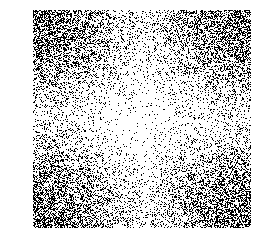

(6, 256, 256, 1)


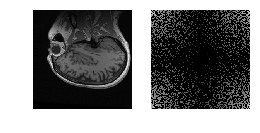

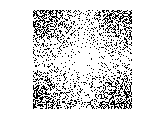

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           (None, 256, 256, 2)  0                                            
__________________________________________________________________________________________________
lambda_821 (Lambda)             (None, 256, 256, 2)  0           input_61[0][0]                   
__________________________________________________________________________________________________
conv2d_589 (Conv2D)             (None, 256, 256, 48) 912         lambda_821[0][0]                 
__________________________________________________________________________________________________
conv2d_590 (Conv2D)             (None, 256, 256, 48) 20784       conv2d_589[0][0]                 
__________________________________________________________________________________________________
conv2d_591

Epoch 1/50
667/667 [==============================] - 119s 179ms/step - loss: 0.1761 - lambda_861_loss: 0.1992 - lambda_866_loss: 0.1761 - val_loss: 0.1149 - val_lambda_861_loss: 0.1409 - val_lambda_866_loss: 0.1149
Epoch 2/50
667/667 [==============================] - 107s 161ms/step - loss: 0.1146 - lambda_861_loss: 0.1364 - lambda_866_loss: 0.1146 - val_loss: 0.1274 - val_lambda_861_loss: 0.1394 - val_lambda_866_loss: 0.1274
Epoch 3/50
667/667 [==============================] - 108s 161ms/step - loss: 0.1059 - lambda_861_loss: 0.1296 - lambda_866_loss: 0.1059 - val_loss: 0.0900 - val_lambda_861_loss: 0.1041 - val_lambda_866_loss: 0.0900
Epoch 4/50
667/667 [==============================] - 108s 161ms/step - loss: 0.0824 - lambda_861_loss: 0.0956 - lambda_866_loss: 0.0824 - val_loss: 0.0841 - val_lambda_861_loss: 0.0944 - val_lambda_866_loss: 0.0841
Epoch 5/50
667/667 [==============================] - 107s 161ms/step - loss: 0.0780 - lambda_861_loss: 0.0909 - lambda_866_loss: 0.0780

Epoch 39/50
667/667 [==============================] - 109s 163ms/step - loss: 0.0521 - lambda_861_loss: 0.0588 - lambda_866_loss: 0.0521 - val_loss: 0.0633 - val_lambda_861_loss: 0.0710 - val_lambda_866_loss: 0.0633
Epoch 40/50
667/667 [==============================] - 109s 163ms/step - loss: 0.0527 - lambda_861_loss: 0.0594 - lambda_866_loss: 0.0527 - val_loss: 0.0601 - val_lambda_861_loss: 0.0660 - val_lambda_866_loss: 0.0601
Epoch 41/50
667/667 [==============================] - 109s 163ms/step - loss: 0.0515 - lambda_861_loss: 0.0578 - lambda_866_loss: 0.0515 - val_loss: 0.0638 - val_lambda_861_loss: 0.0703 - val_lambda_866_loss: 0.0638
Epoch 42/50
667/667 [==============================] - 109s 163ms/step - loss: 0.0532 - lambda_861_loss: 0.0599 - lambda_866_loss: 0.0532 - val_loss: 0.0630 - val_lambda_861_loss: 0.0699 - val_lambda_866_loss: 0.0630
Epoch 43/50
667/667 [==============================] - 109s 163ms/step - loss: 0.0523 - lambda_861_loss: 0.0587 - lambda_866_loss: 0

Epoch 1/50
667/667 [==============================] - 95s 143ms/step - loss: 0.1814 - lambda_901_loss: 0.2016 - lambda_906_loss: 0.1814 - val_loss: 0.1268 - val_lambda_901_loss: 0.1526 - val_lambda_906_loss: 0.1268
Epoch 2/50
667/667 [==============================] - 84s 126ms/step - loss: 0.1189 - lambda_901_loss: 0.1376 - lambda_906_loss: 0.1189 - val_loss: 0.1054 - val_lambda_901_loss: 0.1255 - val_lambda_906_loss: 0.1054
Epoch 3/50
667/667 [==============================] - 84s 127ms/step - loss: 0.1024 - lambda_901_loss: 0.1191 - lambda_906_loss: 0.1024 - val_loss: 0.1021 - val_lambda_901_loss: 0.1162 - val_lambda_906_loss: 0.1021
Epoch 4/50
667/667 [==============================] - 85s 127ms/step - loss: 0.0960 - lambda_901_loss: 0.1127 - lambda_906_loss: 0.0960 - val_loss: 0.0969 - val_lambda_901_loss: 0.1101 - val_lambda_906_loss: 0.0969
Epoch 5/50
667/667 [==============================] - 85s 127ms/step - loss: 0.0892 - lambda_901_loss: 0.1049 - lambda_906_loss: 0.0892 - va

Epoch 39/50
667/667 [==============================] - 85s 127ms/step - loss: 0.0696 - lambda_901_loss: 0.0839 - lambda_906_loss: 0.0696 - val_loss: 0.0786 - val_lambda_901_loss: 0.0923 - val_lambda_906_loss: 0.0786
Epoch 40/50
667/667 [==============================] - 85s 127ms/step - loss: 0.0681 - lambda_901_loss: 0.0822 - lambda_906_loss: 0.0681 - val_loss: 0.0780 - val_lambda_901_loss: 0.0944 - val_lambda_906_loss: 0.0780
Epoch 41/50
667/667 [==============================] - 85s 127ms/step - loss: 0.0676 - lambda_901_loss: 0.0819 - lambda_906_loss: 0.0676 - val_loss: 0.0867 - val_lambda_901_loss: 0.1017 - val_lambda_906_loss: 0.0867
Epoch 42/50
667/667 [==============================] - 85s 127ms/step - loss: 0.0678 - lambda_901_loss: 0.0821 - lambda_906_loss: 0.0678 - val_loss: 0.0816 - val_lambda_901_loss: 0.0947 - val_lambda_906_loss: 0.0816
Epoch 43/50
667/667 [==============================] - 85s 127ms/step - loss: 0.0686 - lambda_901_loss: 0.0830 - lambda_906_loss: 0.0686

667/667 [==============================] - 62s 93ms/step - loss: 0.2583 - lambda_911_loss: 0.3208 - lambda_916_loss: 0.2583 - val_loss: 0.2516 - val_lambda_911_loss: 0.3176 - val_lambda_916_loss: 0.2516
Epoch 12/50
667/667 [==============================] - 63s 94ms/step - loss: 0.2587 - lambda_911_loss: 0.3218 - lambda_916_loss: 0.2587 - val_loss: 0.2696 - val_lambda_911_loss: 0.3351 - val_lambda_916_loss: 0.2696
Epoch 13/50
667/667 [==============================] - 63s 94ms/step - loss: 0.2552 - lambda_911_loss: 0.3182 - lambda_916_loss: 0.2552 - val_loss: 0.2506 - val_lambda_911_loss: 0.3163 - val_lambda_916_loss: 0.2506
Epoch 14/50
667/667 [==============================] - 63s 94ms/step - loss: 0.2548 - lambda_911_loss: 0.3173 - lambda_916_loss: 0.2548 - val_loss: 0.2526 - val_lambda_911_loss: 0.3142 - val_lambda_916_loss: 0.2526
Epoch 15/50
667/667 [==============================] - 62s 93ms/step - loss: 0.2533 - lambda_911_loss: 0.3157 - lambda_916_loss: 0.2533 - val_loss: 0.24

667/667 [==============================] - 62s 93ms/step - loss: 0.2326 - lambda_911_loss: 0.2927 - lambda_916_loss: 0.2326 - val_loss: 0.2325 - val_lambda_911_loss: 0.2969 - val_lambda_916_loss: 0.2325
Epoch 50/50
667/667 [==============================] - 62s 93ms/step - loss: 0.2319 - lambda_911_loss: 0.2915 - lambda_916_loss: 0.2319 - val_loss: 0.2292 - val_lambda_911_loss: 0.2933 - val_lambda_916_loss: 0.2292
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_67 (InputLayer)           (None, 256, 256, 2)  0                                            
__________________________________________________________________________________________________
lambda_921 (Lambda)             (None, 256, 256, 2)  0           input_67[0][0]                   
_______________________________________________________________________________________

667/667 [==============================] - 63s 94ms/step - loss: 0.1991 - lambda_931_loss: 0.2273 - lambda_936_loss: 0.1991 - val_loss: 0.2079 - val_lambda_931_loss: 0.2403 - val_lambda_936_loss: 0.2079
Epoch 20/50
667/667 [==============================] - 63s 94ms/step - loss: 0.1980 - lambda_931_loss: 0.2260 - lambda_936_loss: 0.1980 - val_loss: 0.2245 - val_lambda_931_loss: 0.2467 - val_lambda_936_loss: 0.2245
Epoch 21/50
667/667 [==============================] - 62s 93ms/step - loss: 0.1995 - lambda_931_loss: 0.2273 - lambda_936_loss: 0.1995 - val_loss: 0.2074 - val_lambda_931_loss: 0.2380 - val_lambda_936_loss: 0.2074
Epoch 22/50
667/667 [==============================] - 63s 94ms/step - loss: 0.1969 - lambda_931_loss: 0.2249 - lambda_936_loss: 0.1969 - val_loss: 0.1992 - val_lambda_931_loss: 0.2227 - val_lambda_936_loss: 0.1992
Epoch 23/50
667/667 [==============================] - 62s 92ms/step - loss: 0.1975 - lambda_931_loss: 0.2256 - lambda_936_loss: 0.1975 - val_loss: 0.21

Epoch 1/50
667/667 [==============================] - 76s 114ms/step - loss: 0.3485 - lambda_941_loss: 0.4202 - lambda_946_loss: 0.3485 - val_loss: 0.3013 - val_lambda_941_loss: 0.3666 - val_lambda_946_loss: 0.3013
Epoch 2/50
667/667 [==============================] - 65s 97ms/step - loss: 0.2902 - lambda_941_loss: 0.3567 - lambda_946_loss: 0.2902 - val_loss: 0.2672 - val_lambda_941_loss: 0.3338 - val_lambda_946_loss: 0.2672
Epoch 3/50
667/667 [==============================] - 64s 97ms/step - loss: 0.2737 - lambda_941_loss: 0.3388 - lambda_946_loss: 0.2737 - val_loss: 0.2692 - val_lambda_941_loss: 0.3374 - val_lambda_946_loss: 0.2692
Epoch 4/50
667/667 [==============================] - 65s 97ms/step - loss: 0.2611 - lambda_941_loss: 0.3251 - lambda_946_loss: 0.2611 - val_loss: 0.2712 - val_lambda_941_loss: 0.3403 - val_lambda_946_loss: 0.2712
Epoch 5/50
667/667 [==============================] - 65s 97ms/step - loss: 0.2566 - lambda_941_loss: 0.3203 - lambda_946_loss: 0.2566 - val_lo

667/667 [==============================] - 64s 96ms/step - loss: 0.2067 - lambda_941_loss: 0.2640 - lambda_946_loss: 0.2067 - val_loss: 0.2027 - val_lambda_941_loss: 0.2574 - val_lambda_946_loss: 0.2027
Epoch 40/50
667/667 [==============================] - 65s 97ms/step - loss: 0.2103 - lambda_941_loss: 0.2675 - lambda_946_loss: 0.2103 - val_loss: 0.2058 - val_lambda_941_loss: 0.2622 - val_lambda_946_loss: 0.2058
Epoch 41/50
667/667 [==============================] - 65s 98ms/step - loss: 0.2083 - lambda_941_loss: 0.2661 - lambda_946_loss: 0.2083 - val_loss: 0.2012 - val_lambda_941_loss: 0.2573 - val_lambda_946_loss: 0.2012
Epoch 42/50
667/667 [==============================] - 64s 97ms/step - loss: 0.2080 - lambda_941_loss: 0.2654 - lambda_946_loss: 0.2080 - val_loss: 0.2059 - val_lambda_941_loss: 0.2632 - val_lambda_946_loss: 0.2059
Epoch 43/50
667/667 [==============================] - 65s 98ms/step - loss: 0.2087 - lambda_941_loss: 0.2658 - lambda_946_loss: 0.2087 - val_loss: 0.20

Epoch 1/50
667/667 [==============================] - 75s 113ms/step - loss: 0.2027 - lambda_971_loss: 0.2305 - lambda_976_loss: 0.2027 - val_loss: 0.1788 - val_lambda_971_loss: 0.2090 - val_lambda_976_loss: 0.1788
Epoch 2/50
667/667 [==============================] - 65s 97ms/step - loss: 0.1512 - lambda_971_loss: 0.1754 - lambda_976_loss: 0.1512 - val_loss: 0.1580 - val_lambda_971_loss: 0.1775 - val_lambda_976_loss: 0.1580
Epoch 3/50
667/667 [==============================] - 65s 97ms/step - loss: 0.1366 - lambda_971_loss: 0.1614 - lambda_976_loss: 0.1366 - val_loss: 0.1333 - val_lambda_971_loss: 0.1523 - val_lambda_976_loss: 0.1333
Epoch 4/50
667/667 [==============================] - 65s 97ms/step - loss: 0.1282 - lambda_971_loss: 0.1545 - lambda_976_loss: 0.1282 - val_loss: 0.1309 - val_lambda_971_loss: 0.1625 - val_lambda_976_loss: 0.1309
Epoch 5/50
667/667 [==============================] - 65s 97ms/step - loss: 0.1257 - lambda_971_loss: 0.1517 - lambda_976_loss: 0.1257 - val_lo

667/667 [==============================] - 66s 99ms/step - loss: 0.1001 - lambda_971_loss: 0.1225 - lambda_976_loss: 0.1001 - val_loss: 0.1121 - val_lambda_971_loss: 0.1396 - val_lambda_976_loss: 0.1121
Epoch 40/50
667/667 [==============================] - 66s 99ms/step - loss: 0.0999 - lambda_971_loss: 0.1224 - lambda_976_loss: 0.0999 - val_loss: 0.1141 - val_lambda_971_loss: 0.1427 - val_lambda_976_loss: 0.1141
Epoch 41/50
667/667 [==============================] - 65s 98ms/step - loss: 0.1008 - lambda_971_loss: 0.1238 - lambda_976_loss: 0.1008 - val_loss: 0.1076 - val_lambda_971_loss: 0.1366 - val_lambda_976_loss: 0.1076
Epoch 42/50
667/667 [==============================] - 64s 96ms/step - loss: 0.0995 - lambda_971_loss: 0.1218 - lambda_976_loss: 0.0995 - val_loss: 0.1093 - val_lambda_971_loss: 0.1346 - val_lambda_976_loss: 0.1093
Epoch 43/50
667/667 [==============================] - 64s 96ms/step - loss: 0.1008 - lambda_971_loss: 0.1234 - lambda_976_loss: 0.1008 - val_loss: 0.10

Epoch 1/50
667/667 [==============================] - 76s 113ms/step - loss: 0.2259 - lambda_991_loss: 0.2694 - lambda_996_loss: 0.2259 - val_loss: 0.2054 - val_lambda_991_loss: 0.2452 - val_lambda_996_loss: 0.2054
Epoch 2/50
667/667 [==============================] - 65s 98ms/step - loss: 0.1766 - lambda_991_loss: 0.2147 - lambda_996_loss: 0.1766 - val_loss: 0.1688 - val_lambda_991_loss: 0.2088 - val_lambda_996_loss: 0.1688
Epoch 3/50
667/667 [==============================] - 65s 98ms/step - loss: 0.1681 - lambda_991_loss: 0.2066 - lambda_996_loss: 0.1681 - val_loss: 0.1577 - val_lambda_991_loss: 0.1952 - val_lambda_996_loss: 0.1577
Epoch 4/50
667/667 [==============================] - 65s 98ms/step - loss: 0.1588 - lambda_991_loss: 0.1951 - lambda_996_loss: 0.1588 - val_loss: 0.1586 - val_lambda_991_loss: 0.1876 - val_lambda_996_loss: 0.1586
Epoch 5/50
667/667 [==============================] - 65s 98ms/step - loss: 0.1554 - lambda_991_loss: 0.1920 - lambda_996_loss: 0.1554 - val_lo

667/667 [==============================] - 65s 97ms/step - loss: 0.1239 - lambda_991_loss: 0.1565 - lambda_996_loss: 0.1239 - val_loss: 0.1342 - val_lambda_991_loss: 0.1612 - val_lambda_996_loss: 0.1342
Epoch 40/50
667/667 [==============================] - 65s 97ms/step - loss: 0.1233 - lambda_991_loss: 0.1552 - lambda_996_loss: 0.1233 - val_loss: 0.1288 - val_lambda_991_loss: 0.1570 - val_lambda_996_loss: 0.1288
Epoch 41/50
667/667 [==============================] - 65s 98ms/step - loss: 0.1222 - lambda_991_loss: 0.1539 - lambda_996_loss: 0.1222 - val_loss: 0.1291 - val_lambda_991_loss: 0.1572 - val_lambda_996_loss: 0.1291
Epoch 42/50
667/667 [==============================] - 65s 97ms/step - loss: 0.1233 - lambda_991_loss: 0.1558 - lambda_996_loss: 0.1233 - val_loss: 0.1321 - val_lambda_991_loss: 0.1620 - val_lambda_996_loss: 0.1321
Epoch 43/50
667/667 [==============================] - 66s 98ms/step - loss: 0.1224 - lambda_991_loss: 0.1544 - lambda_996_loss: 0.1224 - val_loss: 0.12

Epoch 1/50
667/667 [==============================] - 76s 114ms/step - loss: 0.2302 - lambda_1011_loss: 0.2638 - lambda_1016_loss: 0.2302 - val_loss: 0.1906 - val_lambda_1011_loss: 0.2221 - val_lambda_1016_loss: 0.1906
Epoch 2/50
667/667 [==============================] - 65s 97ms/step - loss: 0.1732 - lambda_1011_loss: 0.2039 - lambda_1016_loss: 0.1732 - val_loss: 0.1635 - val_lambda_1011_loss: 0.2076 - val_lambda_1016_loss: 0.1635
Epoch 3/50
667/667 [==============================] - 65s 97ms/step - loss: 0.1570 - lambda_1011_loss: 0.1868 - lambda_1016_loss: 0.1570 - val_loss: 0.1509 - val_lambda_1011_loss: 0.1788 - val_lambda_1016_loss: 0.1509
Epoch 4/50
667/667 [==============================] - 65s 97ms/step - loss: 0.1478 - lambda_1011_loss: 0.1775 - lambda_1016_loss: 0.1478 - val_loss: 0.1402 - val_lambda_1011_loss: 0.1732 - val_lambda_1016_loss: 0.1402
Epoch 5/50
667/667 [==============================] - 65s 98ms/step - loss: 0.1435 - lambda_1011_loss: 0.1729 - lambda_1016_los

667/667 [==============================] - 65s 98ms/step - loss: 0.1124 - lambda_1011_loss: 0.1357 - lambda_1016_loss: 0.1124 - val_loss: 0.1192 - val_lambda_1011_loss: 0.1456 - val_lambda_1016_loss: 0.1192
Epoch 39/50
667/667 [==============================] - 65s 97ms/step - loss: 0.1119 - lambda_1011_loss: 0.1352 - lambda_1016_loss: 0.1119 - val_loss: 0.1173 - val_lambda_1011_loss: 0.1452 - val_lambda_1016_loss: 0.1173
Epoch 40/50
667/667 [==============================] - 65s 97ms/step - loss: 0.1130 - lambda_1011_loss: 0.1361 - lambda_1016_loss: 0.1130 - val_loss: 0.1118 - val_lambda_1011_loss: 0.1409 - val_lambda_1016_loss: 0.1118
Epoch 41/50
667/667 [==============================] - 65s 97ms/step - loss: 0.1120 - lambda_1011_loss: 0.1353 - lambda_1016_loss: 0.1120 - val_loss: 0.1136 - val_lambda_1011_loss: 0.1380 - val_lambda_1016_loss: 0.1136
Epoch 42/50
667/667 [==============================] - 65s 97ms/step - loss: 0.1124 - lambda_1011_loss: 0.1357 - lambda_1016_loss: 0.112

Epoch 1/50
667/667 [==============================] - 95s 142ms/step - loss: 0.3403 - lambda_1021_loss: 0.4118 - lambda_1026_loss: 0.3403 - val_loss: 0.2820 - val_lambda_1021_loss: 0.3518 - val_lambda_1026_loss: 0.2820
Epoch 2/50
667/667 [==============================] - 83s 124ms/step - loss: 0.2816 - lambda_1021_loss: 0.3472 - lambda_1026_loss: 0.2816 - val_loss: 0.2840 - val_lambda_1021_loss: 0.3512 - val_lambda_1026_loss: 0.2840
Epoch 3/50
667/667 [==============================] - 83s 124ms/step - loss: 0.2630 - lambda_1021_loss: 0.3263 - lambda_1026_loss: 0.2630 - val_loss: 0.2431 - val_lambda_1021_loss: 0.3079 - val_lambda_1026_loss: 0.2431
Epoch 4/50
667/667 [==============================] - 83s 124ms/step - loss: 0.2522 - lambda_1021_loss: 0.3142 - lambda_1026_loss: 0.2522 - val_loss: 0.2465 - val_lambda_1021_loss: 0.3088 - val_lambda_1026_loss: 0.2465
Epoch 5/50
667/667 [==============================] - 83s 124ms/step - loss: 0.2478 - lambda_1021_loss: 0.3088 - lambda_1026

667/667 [==============================] - 83s 124ms/step - loss: 0.1997 - lambda_1021_loss: 0.2549 - lambda_1026_loss: 0.1997 - val_loss: 0.1955 - val_lambda_1021_loss: 0.2493 - val_lambda_1026_loss: 0.1955
Epoch 39/50
667/667 [==============================] - 83s 124ms/step - loss: 0.2000 - lambda_1021_loss: 0.2546 - lambda_1026_loss: 0.2000 - val_loss: 0.1945 - val_lambda_1021_loss: 0.2479 - val_lambda_1026_loss: 0.1945
Epoch 40/50
667/667 [==============================] - 83s 124ms/step - loss: 0.1980 - lambda_1021_loss: 0.2531 - lambda_1026_loss: 0.1980 - val_loss: 0.1979 - val_lambda_1021_loss: 0.2529 - val_lambda_1026_loss: 0.1979
Epoch 41/50
667/667 [==============================] - 82s 124ms/step - loss: 0.1978 - lambda_1021_loss: 0.2527 - lambda_1026_loss: 0.1978 - val_loss: 0.1982 - val_lambda_1021_loss: 0.2547 - val_lambda_1026_loss: 0.1982
Epoch 42/50
667/667 [==============================] - 82s 123ms/step - loss: 0.1987 - lambda_1021_loss: 0.2535 - lambda_1026_loss: 

Epoch 1/50
667/667 [==============================] - 96s 144ms/step - loss: 0.1711 - lambda_1051_loss: 0.1973 - lambda_1056_loss: 0.1711 - val_loss: 0.1258 - val_lambda_1051_loss: 0.1435 - val_lambda_1056_loss: 0.1258
Epoch 2/50
667/667 [==============================] - 84s 126ms/step - loss: 0.1219 - lambda_1051_loss: 0.1447 - lambda_1056_loss: 0.1219 - val_loss: 0.1263 - val_lambda_1051_loss: 0.1419 - val_lambda_1056_loss: 0.1263
Epoch 3/50
667/667 [==============================] - 84s 126ms/step - loss: 0.1137 - lambda_1051_loss: 0.1340 - lambda_1056_loss: 0.1137 - val_loss: 0.1227 - val_lambda_1051_loss: 0.1407 - val_lambda_1056_loss: 0.1227
Epoch 4/50
667/667 [==============================] - 84s 126ms/step - loss: 0.1043 - lambda_1051_loss: 0.1232 - lambda_1056_loss: 0.1043 - val_loss: 0.1070 - val_lambda_1051_loss: 0.1252 - val_lambda_1056_loss: 0.1070
Epoch 5/50
667/667 [==============================] - 84s 126ms/step - loss: 0.1016 - lambda_1051_loss: 0.1201 - lambda_1056

667/667 [==============================] - 84s 126ms/step - loss: 0.0709 - lambda_1051_loss: 0.0837 - lambda_1056_loss: 0.0709 - val_loss: 0.0799 - val_lambda_1051_loss: 0.0953 - val_lambda_1056_loss: 0.0799
Epoch 39/50
667/667 [==============================] - 84s 126ms/step - loss: 0.0712 - lambda_1051_loss: 0.0844 - lambda_1056_loss: 0.0712 - val_loss: 0.0765 - val_lambda_1051_loss: 0.0856 - val_lambda_1056_loss: 0.0765
Epoch 40/50
667/667 [==============================] - 84s 127ms/step - loss: 0.0707 - lambda_1051_loss: 0.0838 - lambda_1056_loss: 0.0707 - val_loss: 0.0775 - val_lambda_1051_loss: 0.0944 - val_lambda_1056_loss: 0.0775
Epoch 41/50
667/667 [==============================] - 84s 127ms/step - loss: 0.0704 - lambda_1051_loss: 0.0835 - lambda_1056_loss: 0.0704 - val_loss: 0.0782 - val_lambda_1051_loss: 0.0918 - val_lambda_1056_loss: 0.0782
Epoch 42/50
667/667 [==============================] - 84s 127ms/step - loss: 0.0704 - lambda_1051_loss: 0.0832 - lambda_1056_loss: 

Epoch 1/50
667/667 [==============================] - 96s 144ms/step - loss: 0.2189 - lambda_1071_loss: 0.2588 - lambda_1076_loss: 0.2189 - val_loss: 0.1864 - val_lambda_1071_loss: 0.2275 - val_lambda_1076_loss: 0.1864
Epoch 2/50
667/667 [==============================] - 83s 125ms/step - loss: 0.1660 - lambda_1071_loss: 0.1999 - lambda_1076_loss: 0.1660 - val_loss: 0.1484 - val_lambda_1071_loss: 0.1776 - val_lambda_1076_loss: 0.1484
Epoch 3/50
667/667 [==============================] - 84s 125ms/step - loss: 0.1478 - lambda_1071_loss: 0.1805 - lambda_1076_loss: 0.1478 - val_loss: 0.1418 - val_lambda_1071_loss: 0.1786 - val_lambda_1076_loss: 0.1418
Epoch 4/50
667/667 [==============================] - 84s 125ms/step - loss: 0.1415 - lambda_1071_loss: 0.1729 - lambda_1076_loss: 0.1415 - val_loss: 0.1346 - val_lambda_1071_loss: 0.1705 - val_lambda_1076_loss: 0.1346
Epoch 5/50
667/667 [==============================] - 84s 125ms/step - loss: 0.1337 - lambda_1071_loss: 0.1633 - lambda_1076

667/667 [==============================] - 83s 125ms/step - loss: 0.1011 - lambda_1071_loss: 0.1232 - lambda_1076_loss: 0.1011 - val_loss: 0.1073 - val_lambda_1071_loss: 0.1288 - val_lambda_1076_loss: 0.1073
Epoch 39/50
667/667 [==============================] - 84s 126ms/step - loss: 0.1008 - lambda_1071_loss: 0.1230 - lambda_1076_loss: 0.1008 - val_loss: 0.1025 - val_lambda_1071_loss: 0.1248 - val_lambda_1076_loss: 0.1025
Epoch 40/50
667/667 [==============================] - 84s 126ms/step - loss: 0.1004 - lambda_1071_loss: 0.1227 - lambda_1076_loss: 0.1004 - val_loss: 0.1043 - val_lambda_1071_loss: 0.1282 - val_lambda_1076_loss: 0.1043
Epoch 41/50
667/667 [==============================] - 84s 126ms/step - loss: 0.0998 - lambda_1071_loss: 0.1216 - lambda_1076_loss: 0.0998 - val_loss: 0.1045 - val_lambda_1071_loss: 0.1268 - val_lambda_1076_loss: 0.1045
Epoch 42/50
667/667 [==============================] - 83s 125ms/step - loss: 0.1004 - lambda_1071_loss: 0.1225 - lambda_1076_loss: 

Epoch 1/50
667/667 [==============================] - 97s 145ms/step - loss: 0.2243 - lambda_1091_loss: 0.2576 - lambda_1096_loss: 0.2243 - val_loss: 0.1748 - val_lambda_1091_loss: 0.2123 - val_lambda_1096_loss: 0.1748
Epoch 2/50
667/667 [==============================] - 84s 125ms/step - loss: 0.1654 - lambda_1091_loss: 0.1954 - lambda_1096_loss: 0.1654 - val_loss: 0.1660 - val_lambda_1091_loss: 0.2005 - val_lambda_1096_loss: 0.1660
Epoch 3/50
667/667 [==============================] - 84s 126ms/step - loss: 0.1515 - lambda_1091_loss: 0.1795 - lambda_1096_loss: 0.1515 - val_loss: 0.1599 - val_lambda_1091_loss: 0.2004 - val_lambda_1096_loss: 0.1599
Epoch 4/50
667/667 [==============================] - 84s 126ms/step - loss: 0.1421 - lambda_1091_loss: 0.1692 - lambda_1096_loss: 0.1421 - val_loss: 0.1470 - val_lambda_1091_loss: 0.1693 - val_lambda_1096_loss: 0.1470
Epoch 5/50
667/667 [==============================] - 84s 126ms/step - loss: 0.1375 - lambda_1091_loss: 0.1642 - lambda_1096

667/667 [==============================] - 84s 126ms/step - loss: 0.1060 - lambda_1091_loss: 0.1259 - lambda_1096_loss: 0.1060 - val_loss: 0.1108 - val_lambda_1091_loss: 0.1399 - val_lambda_1096_loss: 0.1108
Epoch 39/50
667/667 [==============================] - 84s 125ms/step - loss: 0.1054 - lambda_1091_loss: 0.1251 - lambda_1096_loss: 0.1054 - val_loss: 0.1042 - val_lambda_1091_loss: 0.1205 - val_lambda_1096_loss: 0.1042
Epoch 40/50
667/667 [==============================] - 84s 125ms/step - loss: 0.1046 - lambda_1091_loss: 0.1244 - lambda_1096_loss: 0.1046 - val_loss: 0.1072 - val_lambda_1091_loss: 0.1289 - val_lambda_1096_loss: 0.1072
Epoch 41/50
667/667 [==============================] - 84s 125ms/step - loss: 0.1052 - lambda_1091_loss: 0.1251 - lambda_1096_loss: 0.1052 - val_loss: 0.1047 - val_lambda_1091_loss: 0.1275 - val_lambda_1096_loss: 0.1047
Epoch 42/50
667/667 [==============================] - 83s 125ms/step - loss: 0.1045 - lambda_1091_loss: 0.1238 - lambda_1096_loss: 

Epoch 1/50
667/667 [==============================] - 98s 147ms/step - loss: 0.1936 - lambda_1121_loss: 0.2314 - lambda_1126_loss: 0.1936 - val_loss: 0.1470 - val_lambda_1121_loss: 0.1849 - val_lambda_1126_loss: 0.1470
Epoch 2/50
667/667 [==============================] - 85s 127ms/step - loss: 0.1363 - lambda_1121_loss: 0.1651 - lambda_1126_loss: 0.1363 - val_loss: 0.1418 - val_lambda_1121_loss: 0.1760 - val_lambda_1126_loss: 0.1418
Epoch 3/50
667/667 [==============================] - 85s 128ms/step - loss: 0.1260 - lambda_1121_loss: 0.1538 - lambda_1126_loss: 0.1260 - val_loss: 0.1271 - val_lambda_1121_loss: 0.1510 - val_lambda_1126_loss: 0.1271
Epoch 4/50
667/667 [==============================] - 85s 128ms/step - loss: 0.1221 - lambda_1121_loss: 0.1487 - lambda_1126_loss: 0.1221 - val_loss: 0.1214 - val_lambda_1121_loss: 0.1463 - val_lambda_1126_loss: 0.1214
Epoch 5/50
667/667 [==============================] - 85s 128ms/step - loss: 0.1138 - lambda_1121_loss: 0.1380 - lambda_1126

667/667 [==============================] - 85s 128ms/step - loss: 0.0883 - lambda_1121_loss: 0.1120 - lambda_1126_loss: 0.0883 - val_loss: 0.1043 - val_lambda_1121_loss: 0.1280 - val_lambda_1126_loss: 0.1043
Epoch 39/50
667/667 [==============================] - 85s 128ms/step - loss: 0.0884 - lambda_1121_loss: 0.1122 - lambda_1126_loss: 0.0884 - val_loss: 0.1019 - val_lambda_1121_loss: 0.1307 - val_lambda_1126_loss: 0.1019
Epoch 40/50
667/667 [==============================] - 85s 128ms/step - loss: 0.0881 - lambda_1121_loss: 0.1118 - lambda_1126_loss: 0.0881 - val_loss: 0.0985 - val_lambda_1121_loss: 0.1227 - val_lambda_1126_loss: 0.0985
Epoch 41/50
667/667 [==============================] - 85s 128ms/step - loss: 0.0871 - lambda_1121_loss: 0.1107 - lambda_1126_loss: 0.0871 - val_loss: 0.1060 - val_lambda_1121_loss: 0.1263 - val_lambda_1126_loss: 0.1060
Epoch 42/50
667/667 [==============================] - 85s 128ms/step - loss: 0.0881 - lambda_1121_loss: 0.1117 - lambda_1126_loss: 

Epoch 1/50
667/667 [==============================] - 99s 149ms/step - loss: 0.1693 - lambda_1151_loss: 0.1957 - lambda_1156_loss: 0.1693 - val_loss: 0.1233 - val_lambda_1151_loss: 0.1471 - val_lambda_1156_loss: 0.1233
Epoch 2/50
667/667 [==============================] - 85s 128ms/step - loss: 0.1180 - lambda_1151_loss: 0.1400 - lambda_1156_loss: 0.1180 - val_loss: 0.1100 - val_lambda_1151_loss: 0.1306 - val_lambda_1156_loss: 0.1100
Epoch 3/50
667/667 [==============================] - 85s 128ms/step - loss: 0.1078 - lambda_1151_loss: 0.1267 - lambda_1156_loss: 0.1078 - val_loss: 0.1151 - val_lambda_1151_loss: 0.1411 - val_lambda_1156_loss: 0.1151
Epoch 4/50
667/667 [==============================] - 85s 127ms/step - loss: 0.1002 - lambda_1151_loss: 0.1178 - lambda_1156_loss: 0.1002 - val_loss: 0.1012 - val_lambda_1151_loss: 0.1170 - val_lambda_1156_loss: 0.1012
Epoch 5/50
667/667 [==============================] - 85s 127ms/step - loss: 0.0990 - lambda_1151_loss: 0.1164 - lambda_1156

667/667 [==============================] - 85s 127ms/step - loss: 0.0741 - lambda_1151_loss: 0.0868 - lambda_1156_loss: 0.0741 - val_loss: 0.0874 - val_lambda_1151_loss: 0.1037 - val_lambda_1156_loss: 0.0874
Epoch 39/50
667/667 [==============================] - 85s 127ms/step - loss: 0.0742 - lambda_1151_loss: 0.0867 - lambda_1156_loss: 0.0742 - val_loss: 0.0868 - val_lambda_1151_loss: 0.1002 - val_lambda_1156_loss: 0.0868
Epoch 40/50
667/667 [==============================] - 85s 127ms/step - loss: 0.0742 - lambda_1151_loss: 0.0868 - lambda_1156_loss: 0.0742 - val_loss: 0.0849 - val_lambda_1151_loss: 0.0993 - val_lambda_1156_loss: 0.0849
Epoch 41/50
667/667 [==============================] - 85s 127ms/step - loss: 0.0736 - lambda_1151_loss: 0.0860 - lambda_1156_loss: 0.0736 - val_loss: 0.0890 - val_lambda_1151_loss: 0.1034 - val_lambda_1156_loss: 0.0890
Epoch 42/50
667/667 [==============================] - 85s 127ms/step - loss: 0.0740 - lambda_1151_loss: 0.0864 - lambda_1156_loss: 

Epoch 1/50
667/667 [==============================] - 99s 148ms/step - loss: 0.1882 - lambda_1181_loss: 0.2264 - lambda_1186_loss: 0.1882 - val_loss: 0.1419 - val_lambda_1181_loss: 0.1709 - val_lambda_1186_loss: 0.1419
Epoch 2/50
667/667 [==============================] - 85s 127ms/step - loss: 0.1355 - lambda_1181_loss: 0.1651 - lambda_1186_loss: 0.1355 - val_loss: 0.1261 - val_lambda_1181_loss: 0.1483 - val_lambda_1186_loss: 0.1261
Epoch 3/50
667/667 [==============================] - 85s 127ms/step - loss: 0.1240 - lambda_1181_loss: 0.1501 - lambda_1186_loss: 0.1240 - val_loss: 0.1242 - val_lambda_1181_loss: 0.1496 - val_lambda_1186_loss: 0.1242
Epoch 4/50
667/667 [==============================] - 85s 127ms/step - loss: 0.1179 - lambda_1181_loss: 0.1438 - lambda_1186_loss: 0.1179 - val_loss: 0.1154 - val_lambda_1181_loss: 0.1425 - val_lambda_1186_loss: 0.1154
Epoch 5/50
667/667 [==============================] - 85s 127ms/step - loss: 0.1139 - lambda_1181_loss: 0.1390 - lambda_1186

667/667 [==============================] - 85s 127ms/step - loss: 0.0874 - lambda_1181_loss: 0.1102 - lambda_1186_loss: 0.0874 - val_loss: 0.0993 - val_lambda_1181_loss: 0.1274 - val_lambda_1186_loss: 0.0993
Epoch 39/50
667/667 [==============================] - 85s 127ms/step - loss: 0.0884 - lambda_1181_loss: 0.1115 - lambda_1186_loss: 0.0884 - val_loss: 0.0952 - val_lambda_1181_loss: 0.1203 - val_lambda_1186_loss: 0.0952
Epoch 40/50
667/667 [==============================] - 85s 127ms/step - loss: 0.0875 - lambda_1181_loss: 0.1101 - lambda_1186_loss: 0.0875 - val_loss: 0.1026 - val_lambda_1181_loss: 0.1248 - val_lambda_1186_loss: 0.1026
Epoch 41/50
667/667 [==============================] - 85s 127ms/step - loss: 0.0869 - lambda_1181_loss: 0.1094 - lambda_1186_loss: 0.0869 - val_loss: 0.0998 - val_lambda_1181_loss: 0.1242 - val_lambda_1186_loss: 0.0998
Epoch 42/50
667/667 [==============================] - 85s 127ms/step - loss: 0.0872 - lambda_1181_loss: 0.1100 - lambda_1186_loss: 

Epoch 1/50
667/667 [==============================] - 124s 186ms/step - loss: 0.1466 - lambda_1221_loss: 0.1691 - lambda_1226_loss: 0.1466 - val_loss: 0.1141 - val_lambda_1221_loss: 0.1355 - val_lambda_1226_loss: 0.1141
Epoch 2/50
667/667 [==============================] - 108s 162ms/step - loss: 0.0960 - lambda_1221_loss: 0.1141 - lambda_1226_loss: 0.0960 - val_loss: 0.0937 - val_lambda_1221_loss: 0.1089 - val_lambda_1226_loss: 0.0937
Epoch 3/50
667/667 [==============================] - 108s 163ms/step - loss: 0.0851 - lambda_1221_loss: 0.0992 - lambda_1226_loss: 0.0851 - val_loss: 0.0914 - val_lambda_1221_loss: 0.1044 - val_lambda_1226_loss: 0.0914
Epoch 4/50
667/667 [==============================] - 109s 163ms/step - loss: 0.0803 - lambda_1221_loss: 0.0946 - lambda_1226_loss: 0.0803 - val_loss: 0.0891 - val_lambda_1221_loss: 0.1130 - val_lambda_1226_loss: 0.0891
Epoch 5/50
667/667 [==============================] - 108s 163ms/step - loss: 0.0754 - lambda_1221_loss: 0.0876 - lambda

667/667 [==============================] - 109s 164ms/step - loss: 0.0545 - lambda_1221_loss: 0.0622 - lambda_1226_loss: 0.0545 - val_loss: 0.0646 - val_lambda_1221_loss: 0.0720 - val_lambda_1226_loss: 0.0646
Epoch 39/50
667/667 [==============================] - 109s 164ms/step - loss: 0.0540 - lambda_1221_loss: 0.0618 - lambda_1226_loss: 0.0540 - val_loss: 0.0666 - val_lambda_1221_loss: 0.0771 - val_lambda_1226_loss: 0.0666
Epoch 40/50
667/667 [==============================] - 109s 164ms/step - loss: 0.0541 - lambda_1221_loss: 0.0614 - lambda_1226_loss: 0.0541 - val_loss: 0.0627 - val_lambda_1221_loss: 0.0706 - val_lambda_1226_loss: 0.0627
Epoch 41/50
667/667 [==============================] - 109s 164ms/step - loss: 0.0536 - lambda_1221_loss: 0.0611 - lambda_1226_loss: 0.0536 - val_loss: 0.0670 - val_lambda_1221_loss: 0.0763 - val_lambda_1226_loss: 0.0670
Epoch 42/50
667/667 [==============================] - 109s 163ms/step - loss: 0.0532 - lambda_1221_loss: 0.0602 - lambda_1226_l

Epoch 1/50
667/667 [==============================] - 122s 183ms/step - loss: 0.3316 - lambda_1231_loss: 0.4013 - lambda_1236_loss: 0.3316 - val_loss: 0.2822 - val_lambda_1231_loss: 0.3553 - val_lambda_1236_loss: 0.2822
Epoch 2/50
667/667 [==============================] - 106s 160ms/step - loss: 0.2737 - lambda_1231_loss: 0.3379 - lambda_1236_loss: 0.2737 - val_loss: 0.2629 - val_lambda_1231_loss: 0.3310 - val_lambda_1236_loss: 0.2629
Epoch 3/50
667/667 [==============================] - 107s 161ms/step - loss: 0.2612 - lambda_1231_loss: 0.3246 - lambda_1236_loss: 0.2612 - val_loss: 0.2561 - val_lambda_1231_loss: 0.3154 - val_lambda_1236_loss: 0.2561
Epoch 4/50
667/667 [==============================] - 108s 161ms/step - loss: 0.2495 - lambda_1231_loss: 0.3104 - lambda_1236_loss: 0.2495 - val_loss: 0.2341 - val_lambda_1231_loss: 0.2925 - val_lambda_1236_loss: 0.2341
Epoch 5/50
667/667 [==============================] - 107s 161ms/step - loss: 0.2419 - lambda_1231_loss: 0.3021 - lambda

667/667 [==============================] - 107s 160ms/step - loss: 0.1941 - lambda_1231_loss: 0.2478 - lambda_1236_loss: 0.1941 - val_loss: 0.1940 - val_lambda_1231_loss: 0.2466 - val_lambda_1236_loss: 0.1940
Epoch 39/50
667/667 [==============================] - 107s 160ms/step - loss: 0.1952 - lambda_1231_loss: 0.2490 - lambda_1236_loss: 0.1952 - val_loss: 0.1892 - val_lambda_1231_loss: 0.2423 - val_lambda_1236_loss: 0.1892
Epoch 40/50
667/667 [==============================] - 107s 160ms/step - loss: 0.1938 - lambda_1231_loss: 0.2473 - lambda_1236_loss: 0.1938 - val_loss: 0.1890 - val_lambda_1231_loss: 0.2457 - val_lambda_1236_loss: 0.1890
Epoch 41/50
667/667 [==============================] - 107s 160ms/step - loss: 0.1939 - lambda_1231_loss: 0.2478 - lambda_1236_loss: 0.1939 - val_loss: 0.1896 - val_lambda_1231_loss: 0.2464 - val_lambda_1236_loss: 0.1896
Epoch 42/50
667/667 [==============================] - 107s 160ms/step - loss: 0.1919 - lambda_1231_loss: 0.2454 - lambda_1236_l

Epoch 1/50
667/667 [==============================] - 125s 187ms/step - loss: 0.1572 - lambda_1271_loss: 0.1796 - lambda_1276_loss: 0.1572 - val_loss: 0.1175 - val_lambda_1271_loss: 0.1365 - val_lambda_1276_loss: 0.1175
Epoch 2/50
667/667 [==============================] - 109s 164ms/step - loss: 0.1075 - lambda_1271_loss: 0.1292 - lambda_1276_loss: 0.1075 - val_loss: 0.1028 - val_lambda_1271_loss: 0.1252 - val_lambda_1276_loss: 0.1028
Epoch 3/50
667/667 [==============================] - 109s 164ms/step - loss: 0.0887 - lambda_1271_loss: 0.1031 - lambda_1276_loss: 0.0887 - val_loss: 0.0921 - val_lambda_1271_loss: 0.1079 - val_lambda_1276_loss: 0.0921
Epoch 4/50
667/667 [==============================] - 109s 163ms/step - loss: 0.0824 - lambda_1271_loss: 0.0964 - lambda_1276_loss: 0.0824 - val_loss: 0.0876 - val_lambda_1271_loss: 0.0997 - val_lambda_1276_loss: 0.0876
Epoch 5/50
667/667 [==============================] - 108s 163ms/step - loss: 0.0782 - lambda_1271_loss: 0.0907 - lambda

667/667 [==============================] - 109s 164ms/step - loss: 0.0553 - lambda_1271_loss: 0.0629 - lambda_1276_loss: 0.0553 - val_loss: 0.0704 - val_lambda_1271_loss: 0.0815 - val_lambda_1276_loss: 0.0704
Epoch 39/50
667/667 [==============================] - 109s 164ms/step - loss: 0.0553 - lambda_1271_loss: 0.0625 - lambda_1276_loss: 0.0553 - val_loss: 0.0663 - val_lambda_1271_loss: 0.0743 - val_lambda_1276_loss: 0.0663
Epoch 40/50
667/667 [==============================] - 110s 165ms/step - loss: 0.0546 - lambda_1271_loss: 0.0619 - lambda_1276_loss: 0.0546 - val_loss: 0.0633 - val_lambda_1271_loss: 0.0695 - val_lambda_1276_loss: 0.0633
Epoch 41/50
667/667 [==============================] - 110s 165ms/step - loss: 0.0545 - lambda_1271_loss: 0.0615 - lambda_1276_loss: 0.0545 - val_loss: 0.0655 - val_lambda_1271_loss: 0.0734 - val_lambda_1276_loss: 0.0655
Epoch 42/50
667/667 [==============================] - 110s 165ms/step - loss: 0.0546 - lambda_1271_loss: 0.0624 - lambda_1276_l

Epoch 1/50
667/667 [==============================] - 126s 188ms/step - loss: 0.1831 - lambda_1301_loss: 0.2138 - lambda_1306_loss: 0.1831 - val_loss: 0.1309 - val_lambda_1301_loss: 0.1552 - val_lambda_1306_loss: 0.1309
Epoch 2/50
667/667 [==============================] - 109s 164ms/step - loss: 0.1194 - lambda_1301_loss: 0.1415 - lambda_1306_loss: 0.1194 - val_loss: 0.1131 - val_lambda_1301_loss: 0.1377 - val_lambda_1306_loss: 0.1131
Epoch 3/50
667/667 [==============================] - 110s 164ms/step - loss: 0.1079 - lambda_1301_loss: 0.1268 - lambda_1306_loss: 0.1079 - val_loss: 0.1058 - val_lambda_1301_loss: 0.1291 - val_lambda_1306_loss: 0.1058
Epoch 4/50
667/667 [==============================] - 110s 165ms/step - loss: 0.1026 - lambda_1301_loss: 0.1203 - lambda_1306_loss: 0.1026 - val_loss: 0.1025 - val_lambda_1301_loss: 0.1221 - val_lambda_1306_loss: 0.1025
Epoch 5/50
667/667 [==============================] - 110s 164ms/step - loss: 0.0994 - lambda_1301_loss: 0.1170 - lambda

667/667 [==============================] - 110s 164ms/step - loss: 0.0698 - lambda_1301_loss: 0.0805 - lambda_1306_loss: 0.0698 - val_loss: 0.0765 - val_lambda_1301_loss: 0.0899 - val_lambda_1306_loss: 0.0765
Epoch 39/50
667/667 [==============================] - 110s 164ms/step - loss: 0.0698 - lambda_1301_loss: 0.0810 - lambda_1306_loss: 0.0698 - val_loss: 0.0772 - val_lambda_1301_loss: 0.0900 - val_lambda_1306_loss: 0.0772
Epoch 40/50
667/667 [==============================] - 110s 164ms/step - loss: 0.0689 - lambda_1301_loss: 0.0791 - lambda_1306_loss: 0.0689 - val_loss: 0.0736 - val_lambda_1301_loss: 0.0853 - val_lambda_1306_loss: 0.0736
Epoch 41/50
667/667 [==============================] - 110s 165ms/step - loss: 0.0693 - lambda_1301_loss: 0.0800 - lambda_1306_loss: 0.0693 - val_loss: 0.0751 - val_lambda_1301_loss: 0.0854 - val_lambda_1306_loss: 0.0751
Epoch 42/50
667/667 [==============================] - 110s 164ms/step - loss: 0.0708 - lambda_1301_loss: 0.0822 - lambda_1306_l

Epoch 1/50
667/667 [==============================] - 125s 188ms/step - loss: 0.2117 - lambda_1321_loss: 0.2505 - lambda_1326_loss: 0.2117 - val_loss: 0.1900 - val_lambda_1321_loss: 0.2334 - val_lambda_1326_loss: 0.1900
Epoch 2/50
667/667 [==============================] - 108s 162ms/step - loss: 0.1591 - lambda_1321_loss: 0.1928 - lambda_1326_loss: 0.1591 - val_loss: 0.1452 - val_lambda_1321_loss: 0.1720 - val_lambda_1326_loss: 0.1452
Epoch 3/50
667/667 [==============================] - 109s 163ms/step - loss: 0.1424 - lambda_1321_loss: 0.1746 - lambda_1326_loss: 0.1424 - val_loss: 0.1361 - val_lambda_1321_loss: 0.1657 - val_lambda_1326_loss: 0.1361
Epoch 4/50
667/667 [==============================] - 109s 163ms/step - loss: 0.1327 - lambda_1321_loss: 0.1624 - lambda_1326_loss: 0.1327 - val_loss: 0.1224 - val_lambda_1321_loss: 0.1531 - val_lambda_1326_loss: 0.1224
Epoch 5/50
667/667 [==============================] - 109s 163ms/step - loss: 0.1280 - lambda_1321_loss: 0.1576 - lambda

667/667 [==============================] - 109s 163ms/step - loss: 0.0958 - lambda_1321_loss: 0.1170 - lambda_1326_loss: 0.0958 - val_loss: 0.1033 - val_lambda_1321_loss: 0.1275 - val_lambda_1326_loss: 0.1033
Epoch 39/50
667/667 [==============================] - 109s 163ms/step - loss: 0.0955 - lambda_1321_loss: 0.1165 - lambda_1326_loss: 0.0955 - val_loss: 0.1001 - val_lambda_1321_loss: 0.1227 - val_lambda_1326_loss: 0.1001
Epoch 40/50
667/667 [==============================] - 109s 163ms/step - loss: 0.0954 - lambda_1321_loss: 0.1166 - lambda_1326_loss: 0.0954 - val_loss: 0.0999 - val_lambda_1321_loss: 0.1217 - val_lambda_1326_loss: 0.0999
Epoch 41/50
667/667 [==============================] - 109s 163ms/step - loss: 0.0950 - lambda_1321_loss: 0.1159 - lambda_1326_loss: 0.0950 - val_loss: 0.1026 - val_lambda_1321_loss: 0.1243 - val_lambda_1326_loss: 0.1026
Epoch 42/50
667/667 [==============================] - 108s 163ms/step - loss: 0.0949 - lambda_1321_loss: 0.1155 - lambda_1326_l

Epoch 1/50
667/667 [==============================] - 125s 188ms/step - loss: 0.2151 - lambda_1341_loss: 0.2479 - lambda_1346_loss: 0.2151 - val_loss: 0.1681 - val_lambda_1341_loss: 0.2036 - val_lambda_1346_loss: 0.1681
Epoch 2/50
667/667 [==============================] - 109s 163ms/step - loss: 0.1601 - lambda_1341_loss: 0.1889 - lambda_1346_loss: 0.1601 - val_loss: 0.1487 - val_lambda_1341_loss: 0.1739 - val_lambda_1346_loss: 0.1487
Epoch 3/50
667/667 [==============================] - 109s 163ms/step - loss: 0.1456 - lambda_1341_loss: 0.1730 - lambda_1346_loss: 0.1456 - val_loss: 0.1379 - val_lambda_1341_loss: 0.1669 - val_lambda_1346_loss: 0.1379
Epoch 4/50
667/667 [==============================] - 109s 163ms/step - loss: 0.1398 - lambda_1341_loss: 0.1668 - lambda_1346_loss: 0.1398 - val_loss: 0.1306 - val_lambda_1341_loss: 0.1555 - val_lambda_1346_loss: 0.1306
Epoch 5/50
667/667 [==============================] - 109s 163ms/step - loss: 0.1333 - lambda_1341_loss: 0.1590 - lambda

667/667 [==============================] - 109s 163ms/step - loss: 0.1028 - lambda_1341_loss: 0.1223 - lambda_1346_loss: 0.1028 - val_loss: 0.1066 - val_lambda_1341_loss: 0.1325 - val_lambda_1346_loss: 0.1066
Epoch 39/50
667/667 [==============================] - 109s 163ms/step - loss: 0.1030 - lambda_1341_loss: 0.1225 - lambda_1346_loss: 0.1030 - val_loss: 0.1076 - val_lambda_1341_loss: 0.1303 - val_lambda_1346_loss: 0.1076
Epoch 40/50
667/667 [==============================] - 109s 163ms/step - loss: 0.1014 - lambda_1341_loss: 0.1208 - lambda_1346_loss: 0.1014 - val_loss: 0.1011 - val_lambda_1341_loss: 0.1227 - val_lambda_1346_loss: 0.1011
Epoch 41/50
667/667 [==============================] - 109s 163ms/step - loss: 0.1002 - lambda_1341_loss: 0.1189 - lambda_1346_loss: 0.1002 - val_loss: 0.1019 - val_lambda_1341_loss: 0.1240 - val_lambda_1346_loss: 0.1019
Epoch 42/50
667/667 [==============================] - 109s 163ms/step - loss: 0.1015 - lambda_1341_loss: 0.1210 - lambda_1346_l

Epoch 1/50
667/667 [==============================] - 127s 190ms/step - loss: 0.1729 - lambda_1371_loss: 0.2003 - lambda_1376_loss: 0.1729 - val_loss: 0.1334 - val_lambda_1371_loss: 0.1567 - val_lambda_1376_loss: 0.1334
Epoch 2/50
667/667 [==============================] - 109s 164ms/step - loss: 0.1196 - lambda_1371_loss: 0.1404 - lambda_1376_loss: 0.1196 - val_loss: 0.1205 - val_lambda_1371_loss: 0.1377 - val_lambda_1376_loss: 0.1205
Epoch 3/50
667/667 [==============================] - 109s 164ms/step - loss: 0.1074 - lambda_1371_loss: 0.1263 - lambda_1376_loss: 0.1074 - val_loss: 0.1046 - val_lambda_1371_loss: 0.1237 - val_lambda_1376_loss: 0.1046
Epoch 4/50
667/667 [==============================] - 110s 164ms/step - loss: 0.1009 - lambda_1371_loss: 0.1186 - lambda_1376_loss: 0.1009 - val_loss: 0.0987 - val_lambda_1371_loss: 0.1140 - val_lambda_1376_loss: 0.0987
Epoch 5/50
667/667 [==============================] - 110s 165ms/step - loss: 0.0963 - lambda_1371_loss: 0.1136 - lambda

667/667 [==============================] - 110s 164ms/step - loss: 0.0687 - lambda_1371_loss: 0.0812 - lambda_1376_loss: 0.0687 - val_loss: 0.0820 - val_lambda_1371_loss: 0.0943 - val_lambda_1376_loss: 0.0820
Epoch 39/50
667/667 [==============================] - 110s 164ms/step - loss: 0.0681 - lambda_1371_loss: 0.0802 - lambda_1376_loss: 0.0681 - val_loss: 0.0735 - val_lambda_1371_loss: 0.0860 - val_lambda_1376_loss: 0.0735
Epoch 40/50
667/667 [==============================] - 110s 165ms/step - loss: 0.0685 - lambda_1371_loss: 0.0806 - lambda_1376_loss: 0.0685 - val_loss: 0.0767 - val_lambda_1371_loss: 0.0932 - val_lambda_1376_loss: 0.0767
Epoch 41/50
667/667 [==============================] - 110s 165ms/step - loss: 0.0681 - lambda_1371_loss: 0.0802 - lambda_1376_loss: 0.0681 - val_loss: 0.0764 - val_lambda_1371_loss: 0.0883 - val_lambda_1376_loss: 0.0764
Epoch 42/50
667/667 [==============================] - 110s 165ms/step - loss: 0.0679 - lambda_1371_loss: 0.0796 - lambda_1376_l

Epoch 1/50
667/667 [==============================] - 128s 192ms/step - loss: 0.1664 - lambda_1401_loss: 0.1928 - lambda_1406_loss: 0.1664 - val_loss: 0.1244 - val_lambda_1401_loss: 0.1558 - val_lambda_1406_loss: 0.1244
Epoch 2/50
667/667 [==============================] - 110s 164ms/step - loss: 0.1175 - lambda_1401_loss: 0.1393 - lambda_1406_loss: 0.1175 - val_loss: 0.1080 - val_lambda_1401_loss: 0.1320 - val_lambda_1406_loss: 0.1080
Epoch 3/50
667/667 [==============================] - 110s 165ms/step - loss: 0.1070 - lambda_1401_loss: 0.1256 - lambda_1406_loss: 0.1070 - val_loss: 0.1084 - val_lambda_1401_loss: 0.1277 - val_lambda_1406_loss: 0.1084
Epoch 4/50
667/667 [==============================] - 111s 166ms/step - loss: 0.1000 - lambda_1401_loss: 0.1176 - lambda_1406_loss: 0.1000 - val_loss: 0.1017 - val_lambda_1401_loss: 0.1159 - val_lambda_1406_loss: 0.1017
Epoch 5/50
667/667 [==============================] - 111s 166ms/step - loss: 0.0949 - lambda_1401_loss: 0.1115 - lambda

667/667 [==============================] - 110s 164ms/step - loss: 0.0697 - lambda_1401_loss: 0.0821 - lambda_1406_loss: 0.0697 - val_loss: 0.0773 - val_lambda_1401_loss: 0.0903 - val_lambda_1406_loss: 0.0773
Epoch 39/50
667/667 [==============================] - 110s 164ms/step - loss: 0.0683 - lambda_1401_loss: 0.0804 - lambda_1406_loss: 0.0683 - val_loss: 0.0757 - val_lambda_1401_loss: 0.0887 - val_lambda_1406_loss: 0.0757
Epoch 40/50
667/667 [==============================] - 110s 164ms/step - loss: 0.0687 - lambda_1401_loss: 0.0808 - lambda_1406_loss: 0.0687 - val_loss: 0.0757 - val_lambda_1401_loss: 0.0893 - val_lambda_1406_loss: 0.0757
Epoch 41/50
667/667 [==============================] - 110s 164ms/step - loss: 0.0681 - lambda_1401_loss: 0.0804 - lambda_1406_loss: 0.0681 - val_loss: 0.0755 - val_lambda_1401_loss: 0.0875 - val_lambda_1406_loss: 0.0755
Epoch 42/50
667/667 [==============================] - 110s 165ms/step - loss: 0.0680 - lambda_1401_loss: 0.0803 - lambda_1406_l

Epoch 1/50
667/667 [==============================] - 129s 193ms/step - loss: 0.1696 - lambda_1431_loss: 0.1968 - lambda_1436_loss: 0.1696 - val_loss: 0.1278 - val_lambda_1431_loss: 0.1510 - val_lambda_1436_loss: 0.1278
Epoch 2/50
667/667 [==============================] - 110s 165ms/step - loss: 0.1171 - lambda_1431_loss: 0.1378 - lambda_1436_loss: 0.1171 - val_loss: 0.1132 - val_lambda_1431_loss: 0.1294 - val_lambda_1436_loss: 0.1132
Epoch 3/50
667/667 [==============================] - 110s 166ms/step - loss: 0.1066 - lambda_1431_loss: 0.1257 - lambda_1436_loss: 0.1066 - val_loss: 0.1032 - val_lambda_1431_loss: 0.1215 - val_lambda_1436_loss: 0.1032
Epoch 4/50
667/667 [==============================] - 110s 165ms/step - loss: 0.1000 - lambda_1431_loss: 0.1173 - lambda_1436_loss: 0.1000 - val_loss: 0.1084 - val_lambda_1431_loss: 0.1260 - val_lambda_1436_loss: 0.1084
Epoch 5/50
667/667 [==============================] - 110s 164ms/step - loss: 0.0975 - lambda_1431_loss: 0.1154 - lambda

In [ ]:
under_pattern = ['gaussian_factor=','poisson_center_radius=18_']
under_rates = ['20','25','16_7','33','50']
models_list = ['iiii','iii','k','i',\
               'kk','ii','ik','ki',\
               'kkk','kii','kik','kki','iik','iki','iik',\
               'ikii','kkkk','kiii','kkii','kkik','kkki','kiik','kiki','kiik',\
               'ikkk','ikik','ikki','iiik','iiki','iiik']

for up in under_pattern:
    up_prefix = "../Data/Sampling-patterns/256x256/" + up
    for under in under_rates:
        # undersampling patterns - uncentred k-space
        var_sampling_mask = np.fft.fftshift(~np.load(up_prefix + under + "perc.npy") ,axes = (1,2))
        var_sampling_mask = np.concatenate((var_sampling_mask[:,:,:,np.newaxis],var_sampling_mask[:,:,:,np.newaxis]),\
                                          axis = -1)
        #var_sampling_mask[:] = var_sampling_mask[0,np.newaxis,:,:,:]
        #var_sampling_mask = np.fft.fftshift(var_sampling_mask,axes = (1,2))
        print("Undersampling:", 1.0*var_sampling_mask.sum()/var_sampling_mask.size)
        print("Mask type:",  var_sampling_mask.dtype)
        plt.figure()
        plt.imshow(var_sampling_mask[0,:,:,0],cmap = "gray")
        plt.axis("off")
        plt.show()
        indexes = np.random.choice(np.arange(var_sampling_mask.shape[0],dtype =int),kspace_val.shape[0],replace = True)
        val_var_sampling_mask = (var_sampling_mask[indexes])
        kspace_val_copy = kspace_val.copy()
        kspace_val_copy[val_var_sampling_mask] = 0
        val_var_sampling_mask = val_var_sampling_mask.astype(np.float32)
    
        seed = 905
        image_datagen1 = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.05,
            height_shift_range=0.05,
            shear_range=0.05,
            zoom_range=0.05,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest')

        image_datagen2 = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.05,
            height_shift_range=0.05,
            shear_range=0.05,
            zoom_range=0.05,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest')

        
        image_generator1 = image_datagen1.flow(rec_train[:,:,:,0,np.newaxis],batch_size = batch_size,seed = seed)
        image_generator2 = image_datagen2.flow(rec_train[:,:,:,1,np.newaxis],batch_size = batch_size,seed = seed)

        # combine generators into one which yields image and masks
        combined = combine_generator(image_generator1,image_generator2, var_sampling_mask)

        
        # sample data augmentation
        for ii in combined:
            print(ii[1][1].shape)
            plt.figure()
            plt.subplot(131)
            plt.imshow(ii[1][1][4,:,:,0],cmap = 'gray')
            plt.axis("off")
            plt.subplot(132)
            plt.imshow(np.log(1+np.abs(ii[0][0][4,:,:,0] + 1j*ii[0][0][4,:,:,1])),cmap = 'gray')
            plt.axis("off")
            plt.show()
            plt.subplot(133)
            plt.imshow(ii[0][1][4,:,:,0],cmap = 'gray')
            plt.axis("off")
            plt.show()
            break
        for jj in models_list:
            model = fsnet.deep_cascade_flat_unrolled(jj, H, W)
            opt = Adam(lr = 1e-3,decay = 1e-5)
            model.compile(loss = [fsnet.nrmse_min_max,fsnet.nrmse_min_max],loss_weights=[0.0,1.0],optimizer=opt)
            up_name = up.split("_")[0]
            model_name = "../Models/flat_unrolled_cascade_" + jj + "_" + up_name + "_" + under + ".hdf5"

            #if os.path.isfile(model_name):
            #    model.load_weights(model_name)
            print(model.summary())
            print(model_name)
            # Checkpoint callback to save model  along the epochs
            checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                     monitor='val_loss',verbose=0,\
                                     save_best_only=True, save_weights_only = True)


            hist = model.fit_generator(combined,
                         epochs=epochs,
                         steps_per_epoch=rec_train.shape[0]//batch_size,
                         verbose=1,
                         validation_data= ([kspace_val_copy,val_var_sampling_mask],[rec_val,rec_val_abs]),
                         callbacks=[checkpoint,earlyStopping])